In [1]:
import os
import cv2
import glob
import numpy as np
import matplotlib.pyplot as plt
import torch
# from skimage.metrics import structural_similarity, peak_signal_noise_ratio
import matplotlib.patches as patches


import models.modules.Sakuya_arch_VaryWin as Sakuya_arch

In [2]:
def read_image(path):
    """Read image from the given path.

    Args:
        path (str): The path of the image.

    Returns:
        array: RGB image.
    """
    # RGB
    img = cv2.imread(path)[:, :, ::-1]
    return img

def read_seq_images(path):
    """Read a sequence of images.

    Args:
        path (str): The path of the image sequence.

    Returns:
        array: (N, H, W, C) RGB images.
    """
    imgs_path = sorted(glob.glob(os.path.join(path, '*')))
    imgs = [read_image(img_path) for img_path in imgs_path]
    imgs = np.stack(imgs, axis=0)
    return imgs

In [3]:
def window_reverse(windows, window_size, B, D, H, W):
    """Reverse window partition.

    Args:
        windows (torch.Tensor): (B*nW, D, Wh, Ww, C)
        window_size (tuple[int]): Window size
        B (int): Number of batches
        D (int): Number of frames
        H (int): Height of image
        W (int): Width of image

    Returns:
        x: (B, D, H, W, C)
    """
    x = windows.view(B, H // window_size[0], W // window_size[1], D, window_size[0], window_size[1], -1)
    x = x.permute(0, 3, 1, 4, 2, 5, 6).contiguous().view(B, D, H, W, -1)
    return x

In [27]:
dataset_root = '/mnt/DataCollectionHiPerf/vimeo_septuplet/sequences/00001/0001/'
path = sorted(glob.glob(os.path.join(dataset_root, '*')))

imgs_LR = read_seq_images(dataset_root)[:, :64, :112]
imgs_LR = imgs_LR.astype(np.float32) / 255.
imgs_LR = torch.from_numpy(imgs_LR).permute(0, 3, 1, 2).contiguous()

imgs_GT = read_seq_images(dataset_root.replace('_LR', ''))[:, :61, :112]

inputs_index = [0, 2, 4, 6]

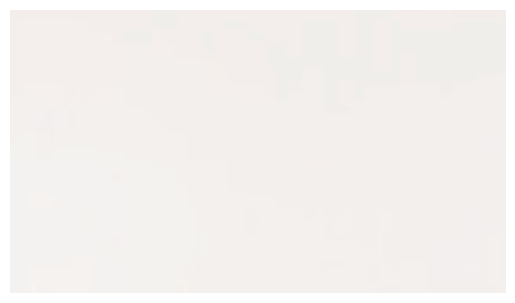

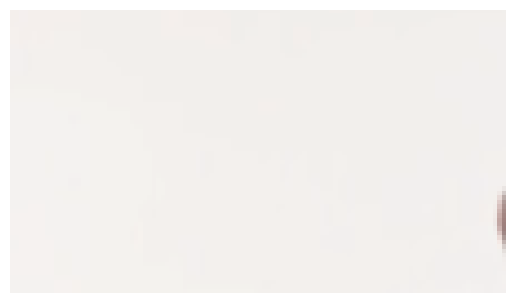

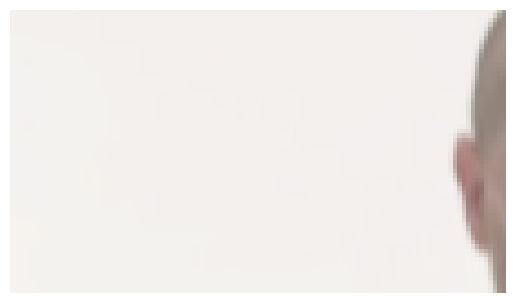

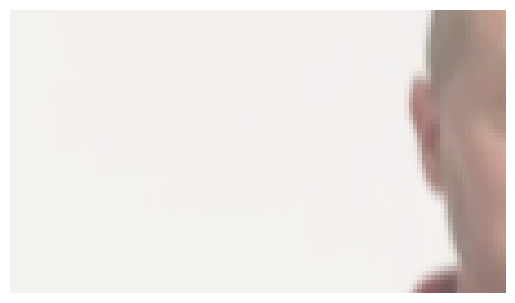

In [28]:
for i in range(4):
    fig, ax = plt.subplots()
    ax.imshow(imgs_LR[i*2].permute(1, 2, 0))
    ax.axis('off')
    plt.savefig('img{}_LR.png'.format(i*2 + 1), bbox_inches='tight', transparent=True, dpi=360)
    plt.show()

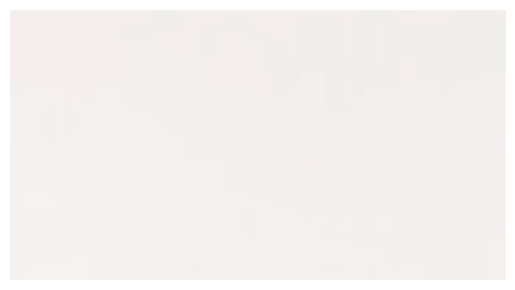

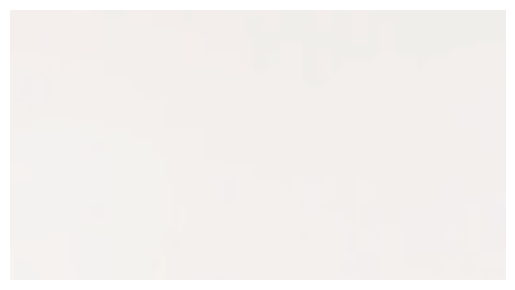

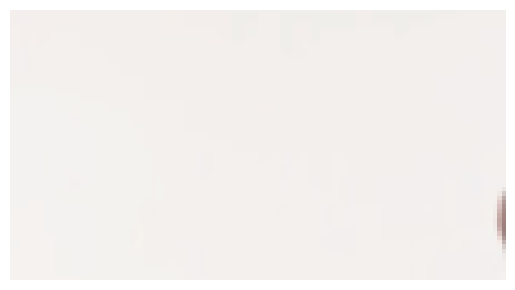

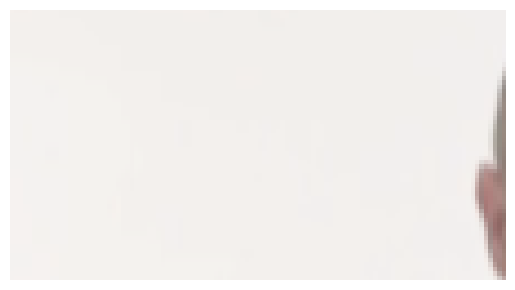

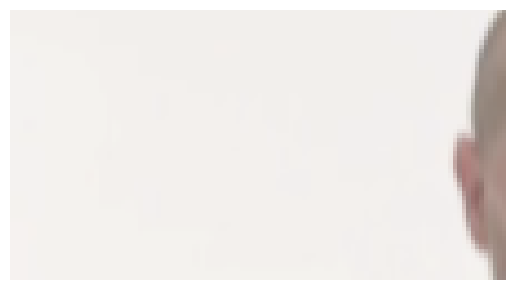

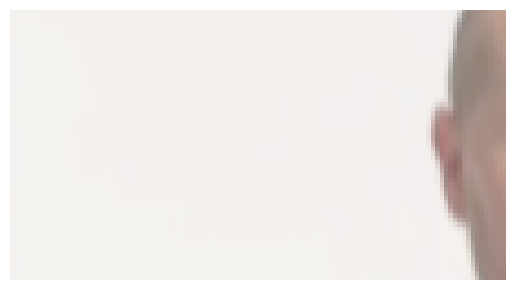

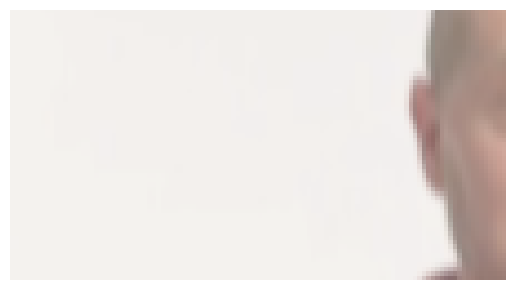

In [29]:
for i in range(7):
    fig, ax = plt.subplots()
    ax.imshow(imgs_GT[i])
    ax.axis('off')
    plt.savefig('img{}_GT.png'.format(i + 1), bbox_inches='tight', transparent=True, dpi=360)
    plt.show()

In [30]:
model_path = '/home/luming/transformer2/experiments/f96Varywin/models/40000_G.pth'
model = Sakuya_arch.VSTSRTransformer(back_RBs=10)
device = torch.device('cpu')

model.load_state_dict(torch.load(model_path), strict=True)
model.eval()
model = model.to(device)

In [31]:
enc_attn_outputs = []
enc_attn_weights = []
dec_attn_outputs = []
dec_attn_weights = []
enc_shift_attn_outputs = []
enc_shift_attn_weights = []
dec_shift_attn_outputs = []
dec_shift_attn_weights = []
hooks = []

In [32]:
def enc_hook(module, input, output):
    #print(module)
    enc_attn_outputs.append(output[0])
    enc_attn_weights.append(output[1])
def dec_hook(module, input, output):
    #print(module)
    dec_attn_outputs.append(output[0])
    dec_attn_weights.append(output[1])
    
def shift_enc_hook(module, input, output):
    #print(module)
    enc_shift_attn_outputs.append(output[0])
    enc_shift_attn_weights.append(output[1])
def shift_dec_hook(module, input, output):
    #print(module)
    dec_shift_attn_outputs.append(output[0])
    dec_shift_attn_weights.append(output[1])

In [33]:
for encoder_layer in model.encoder_layers.children():
    hooks.append(encoder_layer.blocks[0].attn.register_forward_hook(enc_hook))
    hooks.append(encoder_layer.blocks[1].attn.register_forward_hook(shift_enc_hook))
for decoder_layer in model.decoder_layers.children():
    hooks.append(decoder_layer.blocks[0].attn2.register_forward_hook(dec_hook))
    hooks.append(decoder_layer.blocks[1].attn2.register_forward_hook(shift_dec_hook))

In [34]:
inputs = imgs_LR[::2].unsqueeze(0)
with torch.no_grad():
    outputs = model(inputs)
outputs = outputs.squeeze().clamp(0, 1).numpy()

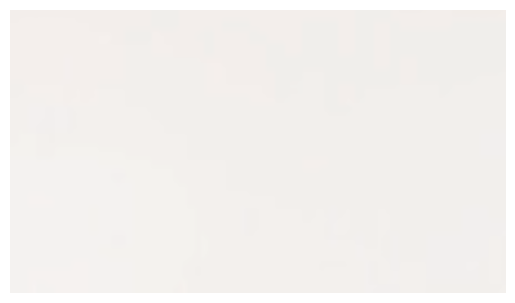

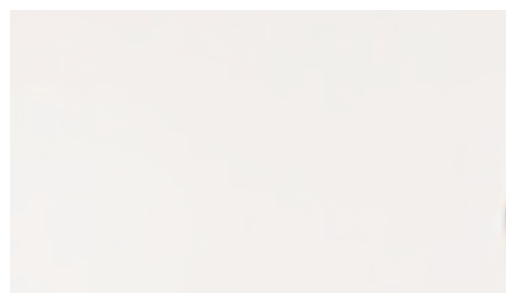

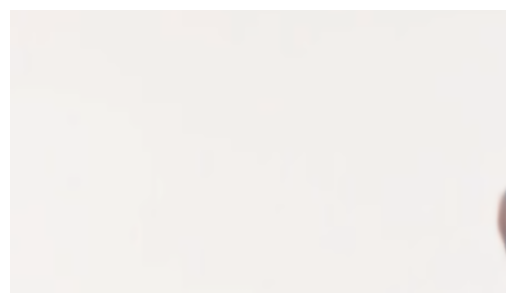

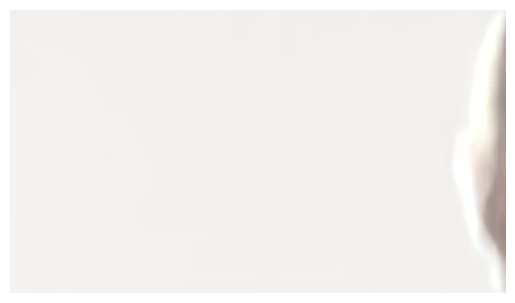

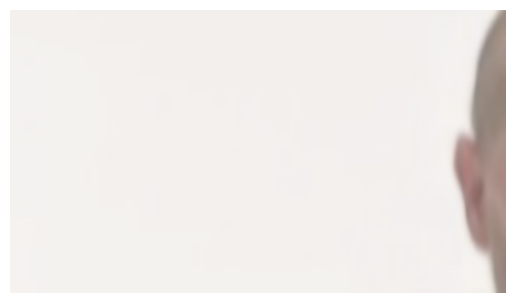

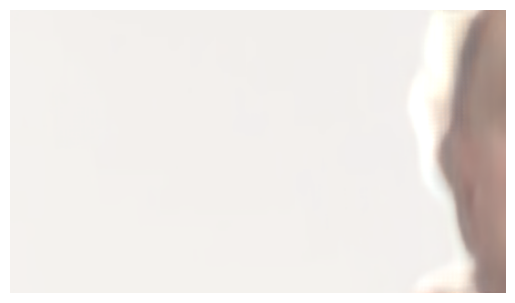

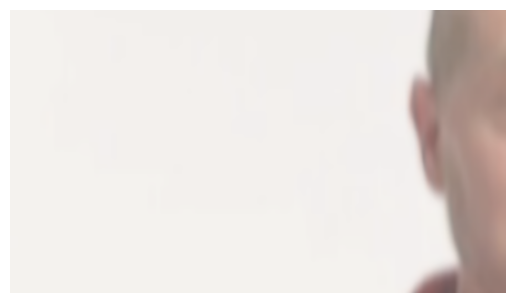

In [35]:
for i in range(7):
    fig, ax = plt.subplots()
    output = (outputs[i].squeeze().transpose((1, 2, 0)) * 255.0).round().astype(np.uint8)
    target = imgs_GT[i]
#     psnr = peak_signal_noise_ratio(output, target)
#     print(psnr)
    ax.imshow(output)
    ax.axis('off')
    plt.savefig('img{}_output.png'.format(i + 1), bbox_inches='tight', transparent=True, dpi=360)
    plt.show()

In [36]:
for hook in hooks:
    hook.remove()

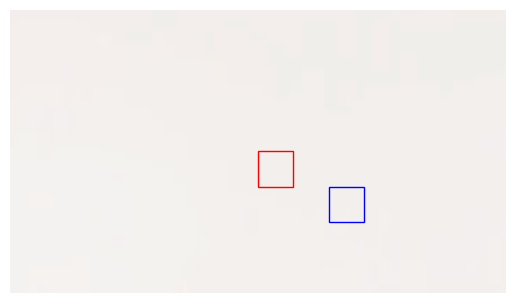

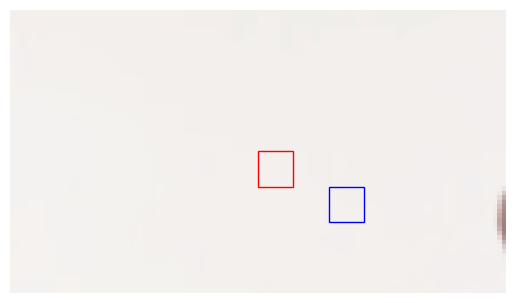

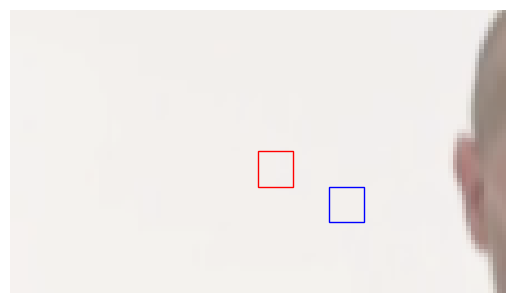

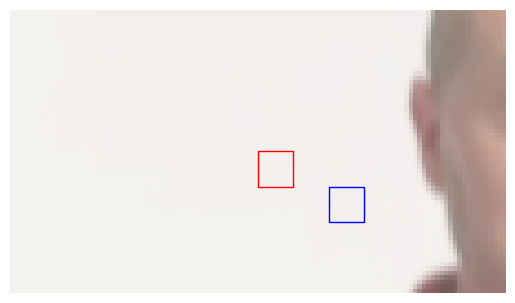

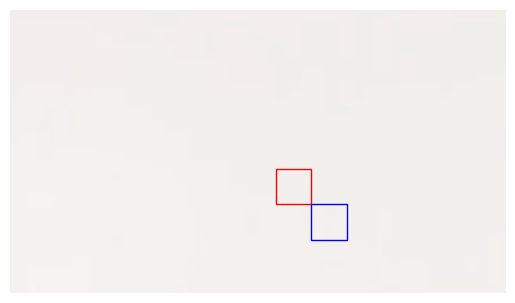

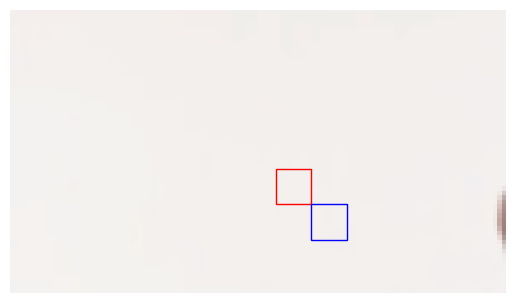

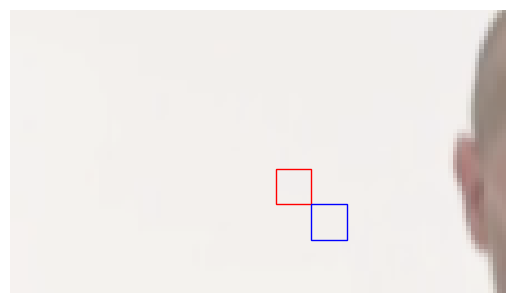

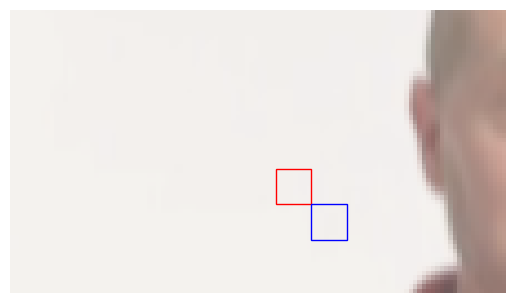

In [37]:
frame_idx = 1
loc11 = [62, 36]
loc12 = [62, 38]
loc21 = [73, 45]
loc22 = [75, 46]
windows1 = (loc11[0]//8 * 8, loc11[1]//8 * 8)
windows2 = (loc21[0]//8 * 8, loc21[1]//8 * 8)

# for i in range(4):
#     fig, ax = plt.subplots()
#     ax.imshow(imgs_LR[i*2].permute(1, 2, 0))
#     rect = patches.Rectangle((windows1[0]-0.5, windows1[1]-0.5), 8, 8, linewidth=1, edgecolor='r', facecolor='none')
#     ax.add_patch(rect)
#     rect = patches.Rectangle((windows2[0]-0.5, windows2[1]-0.5), 8, 8, linewidth=1, edgecolor='b', facecolor='none')
#     ax.add_patch(rect)
#     ax.axis('off')
#     plt.show()

for i in range(4):
    fig, ax = plt.subplots()
    ax.imshow(imgs_LR[i*2].permute(1, 2, 0))
    rect = patches.Rectangle((windows1[0]-0.5, windows1[1]-0.5), 8, 8, linewidth=1, edgecolor='r', facecolor='none')
    ax.add_patch(rect)
    rect = patches.Rectangle((windows2[0]-0.5, windows2[1]-0.5), 8, 8, linewidth=1, edgecolor='b', facecolor='none')
    ax.add_patch(rect)
    ax.axis('off')
    plt.savefig('img{}_attn_encoder.png'.format(i*2 + 1), bbox_inches='tight', transparent=True, dpi=360)
    plt.show()

windows1 = ((loc11[0]-4)//8 * 8 + 4, (loc11[1]-4)//8 * 8 + 4)
windows2 = ((loc21[0]-4)//8 * 8 + 4, (loc21[1]-4)//8 * 8 + 4)

for i in range(4):
    fig, ax = plt.subplots()
    ax.imshow(imgs_LR[i*2].permute(1, 2, 0))
    rect = patches.Rectangle((windows1[0]-0.5, windows1[1]-0.5), 8, 8, linewidth=1, edgecolor='r', facecolor='none')
    ax.add_patch(rect)
    rect = patches.Rectangle((windows2[0]-0.5, windows2[1]-0.5), 8, 8, linewidth=1, edgecolor='b', facecolor='none')
    ax.add_patch(rect)
    ax.axis('off')
    plt.savefig('img{}_shift_window_attn_encoder.png'.format(i*2 + 1), bbox_inches='tight', transparent=True, dpi=360)
    plt.show()


# Attention from first encoder 

In [38]:
frame_idx = 1
loc11 = [62, 36]
loc12 = [62, 38]
loc21 = [75, 43]
loc22 = [75, 45]
windows1 = (loc11[0]//8 * 8, loc11[1]//8 * 8)
windows2 = (loc21[0]//8 * 8, loc21[1]//8 * 8)

In [41]:
enc_attn_weights[0].shape

torch.Size([448, 2, 64, 64])

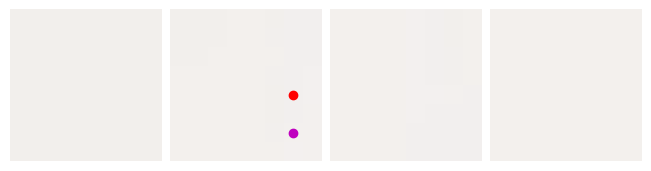

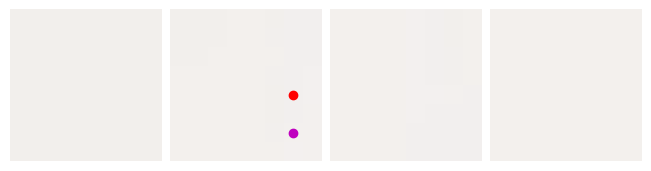

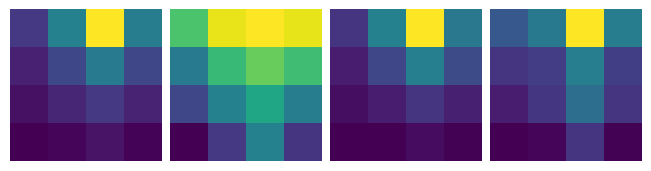

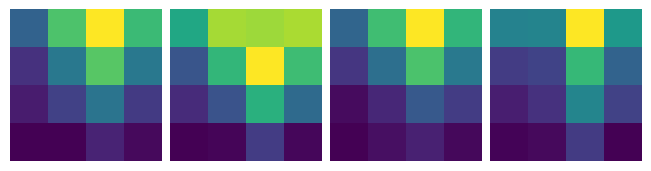

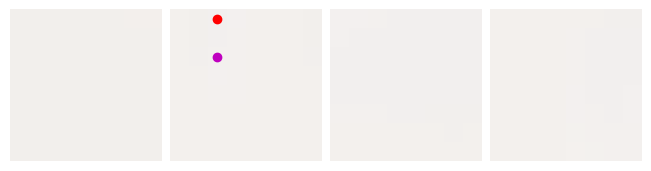

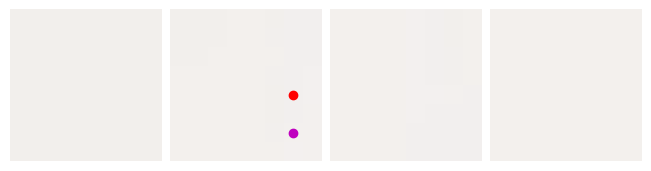

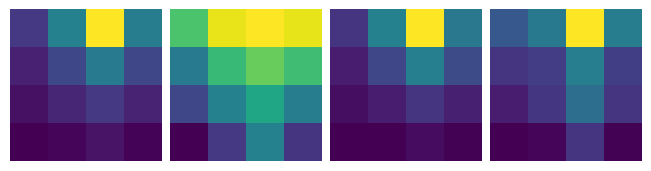

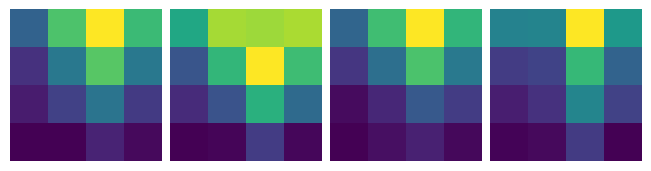

RuntimeError: shape '[1, 4, 64, 112, 4, 8, 8]' is invalid for input of size 1835008

In [44]:
frame_idx = 1
loc11 = [62, 36]
loc12 = [62, 38]
loc21 = [73, 45]
loc22 = [75, 46]
windows1 = (loc11[0]//8 * 8, loc11[1]//8 * 8)
windows2 = (loc21[0]//8 * 8, loc21[1]//8 * 8)

fig, axs = plt.subplots(1, 4, constrained_layout=True)
for i in range(4): 
    test = imgs_LR[i*2, :,windows1[1]:windows1[1]+8, windows1[0]:windows1[0]+8].permute(1, 2, 0)
    if i == frame_idx:
            axs[i].plot(loc11[0]-windows1[0],loc11[1]-windows1[1],'ro')
            axs[i].plot(loc12[0]-windows1[0],loc12[1]-windows1[1],'mo')
    axs[i].imshow(test)
    axs[i].axis('off')
plt.savefig('window1.png', dpi=360, bbox_inches='tight', transparent=True)


for i in range(2):
    attn_weights = enc_attn_weights[0][:, i, ...].view(-1, 4, 4, 4, 64)
    x = window_reverse(attn_weights, (4, 4), 1, 4, 64, 112)
    x = x.view(1, 4, 64, 112, 4, 4, 4)
    fig, axs = plt.subplots(1, 4, constrained_layout=True)
    for j in range(4):
        axs[j].imshow(x[0, frame_idx, loc11[1], loc11[0], j])
        axs[j].axis('off')
    plt.savefig('point1_window1_encoder1_attention_head{}.png'.format(i), dpi=360, bbox_inches='tight', transparent=True)
    plt.show()
for i in range(2):
    attn_weights = enc_attn_weights[0][:, i, ...].view(-1, 4, 4, 4, 64)
    x = window_reverse(attn_weights, (8, 8), 1, 4, 64, 112)
    x = x.view(1, 4, 64, 112, 4, 8, 8)
    fig, axs = plt.subplots(1, 4, constrained_layout=True)
    for j in range(4):
        axs[j].imshow(x[0, frame_idx, loc12[1], loc12[0], j])
        axs[j].axis('off')
    plt.savefig('point2_window1_encoder1_attention_head{}.png'.format(i), dpi=360, bbox_inches='tight', transparent=True)
        
fig, axs = plt.subplots(1, 4, constrained_layout=True)
for i in range(4): 
    test = imgs_LR[i*2, :,windows2[1]:windows2[1]+8, windows2[0]:windows2[0]+8].permute(1, 2, 0)
    if i == frame_idx:
            axs[i].plot(loc21[0]-windows2[0],loc21[1]-windows2[1],'bo')
            axs[i].plot(loc22[0]-windows2[0],loc22[1]-windows2[1],'co')
    axs[i].imshow(test)
    axs[i].axis('off')
plt.savefig('window2.png', dpi=360, bbox_inches='tight', transparent=True)


for i in range(2):
    attn_weights = enc_attn_weights[0][:, i, ...].view(-1, 4, 8, 8, 256)
    x = window_reverse(attn_weights, (8, 8), 1, 4, 64, 112)
    x = x.view(1, 4, 64, 112, 4, 8, 8)
    fig, axs = plt.subplots(1, 4, constrained_layout=True)
    for j in range(4):
        axs[j].imshow(x[0, frame_idx, loc21[1], loc21[0], j])
        axs[j].axis('off')
    plt.savefig('point3_window2_encoder1_attention_head{}.png'.format(i), dpi=360, bbox_inches='tight', transparent=True)
        
for i in range(2):
    attn_weights = enc_attn_weights[0][:, i, ...].view(-1, 4, 8, 8, 256)
    x = window_reverse(attn_weights, (8, 8), 1, 4, 64, 112)
    x = x.view(1, 4, 64, 112, 4, 8, 8)
    fig, axs = plt.subplots(1, 4, constrained_layout=True)
    for j in range(4):
        axs[j].imshow(x[0, frame_idx, loc22[1], loc22[0], j])
        axs[j].axis('off')
    plt.savefig('point4_window2_encoder1_attention_head{}.png'.format(i), dpi=360, bbox_inches='tight', transparent=True)

In [43]:
frame_idx = 1
loc11 = [62, 36]
loc12 = [62, 38]
loc21 = [73, 45]
loc22 = [75, 46]
windows1 = ((loc11[0]-4)//8 * 8 + 4, (loc11[1]-4)//8 * 8 + 4)
windows2 = ((loc21[0]-4)//8 * 8 + 4, (loc21[1]-4)//8 * 8 + 4)

fig, axs = plt.subplots(1, 4, constrained_layout=True)
for i in range(4): 
    test = imgs_LR[i*2, :,windows1[1]:windows1[1]+8, windows1[0]:windows1[0]+8].permute(1, 2, 0)
    if i == frame_idx:
            axs[i].plot(loc11[0]-windows1[0],loc11[1]-windows1[1],'ro')
            axs[i].plot(loc12[0]-windows1[0],loc12[1]-windows1[1],'mo')
    axs[i].imshow(test)
    axs[i].axis('off')
plt.savefig('shift_window1.png', dpi=360, bbox_inches='tight', transparent=True)


for i in range(2):
    attn_weights = enc_shift_attn_weights[0][:, i, ...].view(-1, 4, 8, 8, 256)
    x = window_reverse(attn_weights, (8, 8), 1, 4, 64, 112)
    x = x.view(1, 4, 64, 112, 4, 8, 8)
    x = torch.roll(x, shifts=(4, 4), dims=(2, 3))
    fig, axs = plt.subplots(1, 4, constrained_layout=True)
    for j in range(4):
        axs[j].imshow(x[0, frame_idx, loc11[1], loc11[0], j])
        axs[j].axis('off')
    plt.savefig('point1_shift_window1_encoder1_attention_head{}.png'.format(i), dpi=360, bbox_inches='tight', transparent=True)

for i in range(2):
    attn_weights = enc_shift_attn_weights[0][:, i, ...].view(-1, 4, 8, 8, 256)
    x = window_reverse(attn_weights, (8, 8), 1, 4, 64, 112)
    x = x.view(1, 4, 64, 112, 4, 8, 8)
    x = torch.roll(x, shifts=(4, 4), dims=(2, 3))
    fig, axs = plt.subplots(1, 4, constrained_layout=True)
    for j in range(4):
        axs[j].imshow(x[0, frame_idx, loc12[1], loc12[0], j])
        axs[j].axis('off')
    plt.savefig('point2_shift_window1_encoder1_attention_head{}.png'.format(i), dpi=360, bbox_inches='tight', transparent=True)

fig, axs = plt.subplots(1, 4, constrained_layout=True)
for i in range(4): 
    test = imgs_LR[i*2, :,windows2[1]:windows2[1]+8, windows2[0]:windows2[0]+8].permute(1, 2, 0)
    if i == frame_idx:
            axs[i].plot(loc21[0]-windows2[0],loc21[1]-windows2[1],'bo')
            axs[i].plot(loc22[0]-windows2[0],loc22[1]-windows2[1],'co')
    axs[i].imshow(test)
    axs[i].axis('off')
plt.savefig('shift_window2.png', dpi=360, bbox_inches='tight', transparent=True)


for i in range(2):
    attn_weights = enc_shift_attn_weights[0][:, i, ...].view(-1, 4, 8, 8, 256)
    x = window_reverse(attn_weights, (8, 8), 1, 4, 64, 112)
    x = x.view(1, 4, 64, 112, 4, 8, 8)
    x = torch.roll(x, shifts=(4, 4), dims=(2, 3))
    fig, axs = plt.subplots(1, 4, constrained_layout=True)
    for j in range(4):
        axs[j].imshow(x[0, frame_idx, loc21[1], loc21[0], j])
        axs[j].axis('off')
    plt.savefig('point3_shift_window2_encoder1_attention_head{}.png'.format(i), dpi=360, bbox_inches='tight', transparent=True)

for i in range(2):
    attn_weights = enc_shift_attn_weights[0][:, i, ...].view(-1, 4, 8, 8, 256)
    x = window_reverse(attn_weights, (8, 8), 1, 4, 64, 112)
    x = x.view(1, 4, 64, 112, 4, 8, 8)
    x = torch.roll(x, shifts=(4, 4), dims=(2, 3))
    fig, axs = plt.subplots(1, 4, constrained_layout=True)
    for j in range(4):
        axs[j].imshow(x[0, frame_idx, loc22[1], loc22[0], j])
        axs[j].axis('off')
    plt.savefig('point4_shift_window2_encoder1_attention_head{}.png'.format(i), dpi=360, bbox_inches='tight', transparent=True)

RuntimeError: view size is not compatible with input tensor's size and stride (at least one dimension spans across two contiguous subspaces). Use .reshape(...) instead.

# Attention from last encoder 

<ipython-input-22-6e839864e839>:42: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  fig, axs = plt.subplots(1, 4, constrained_layout=True)


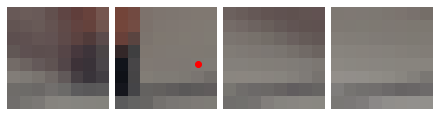

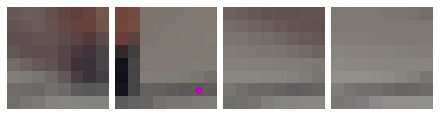

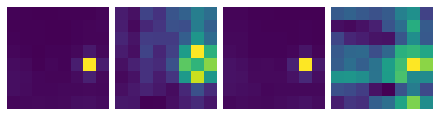

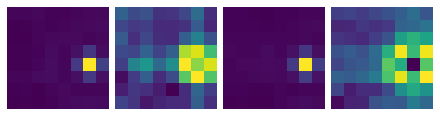

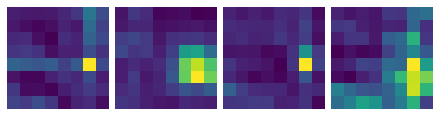

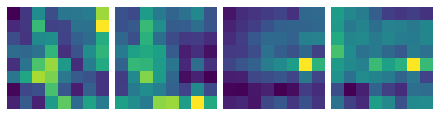

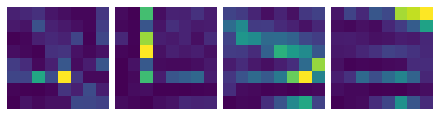

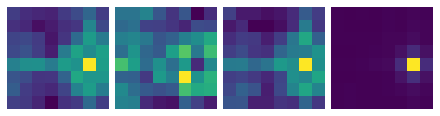

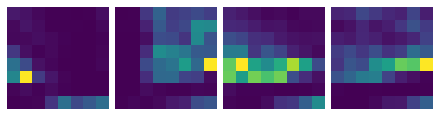

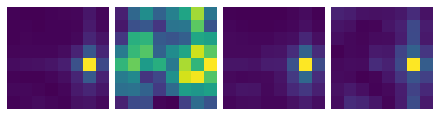

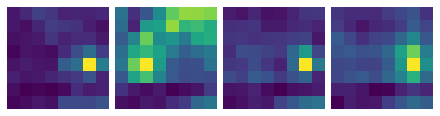

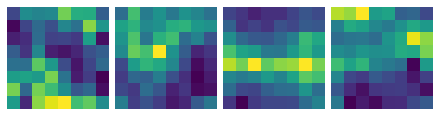

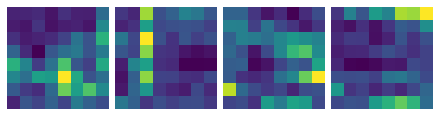

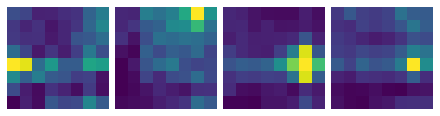

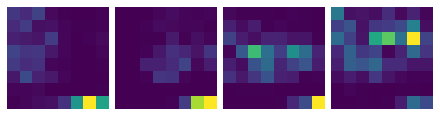

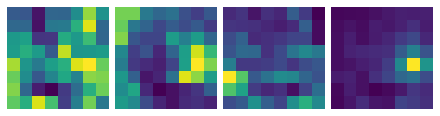

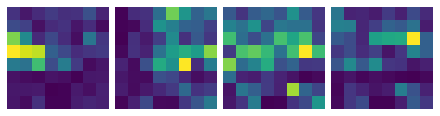

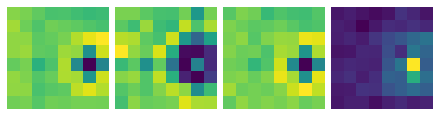

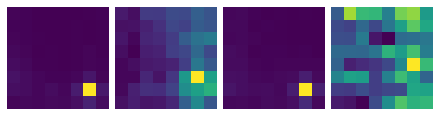

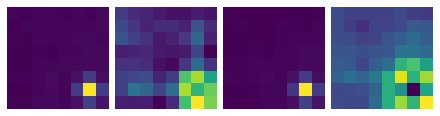

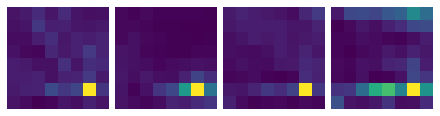

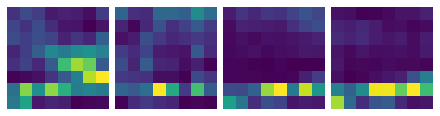

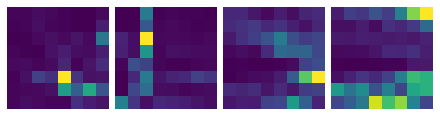

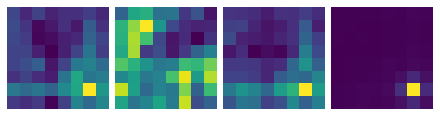

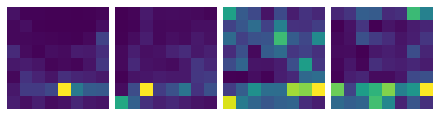

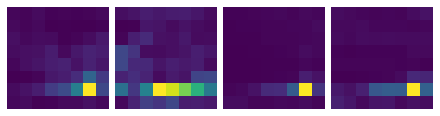

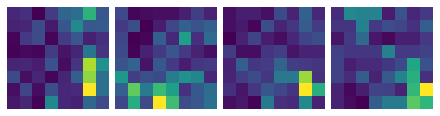

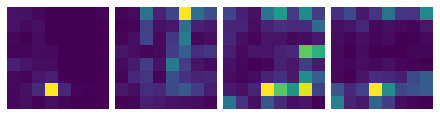

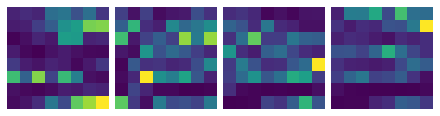

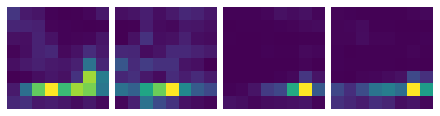

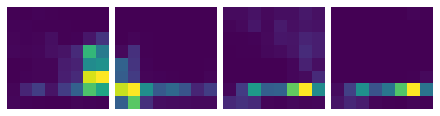

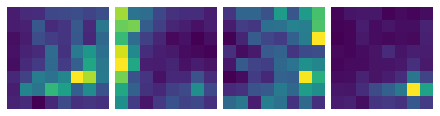

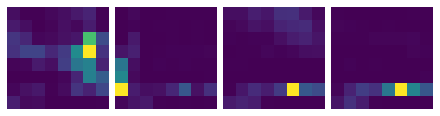

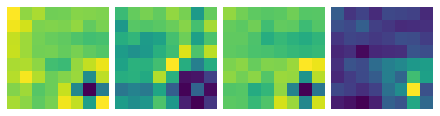

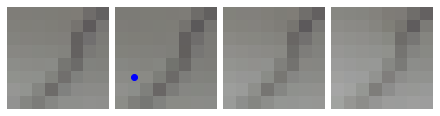

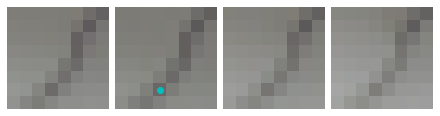

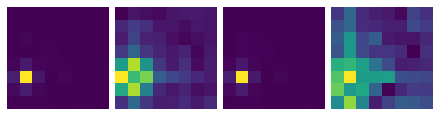

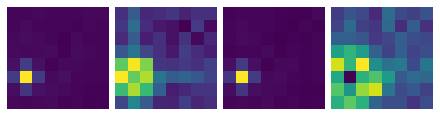

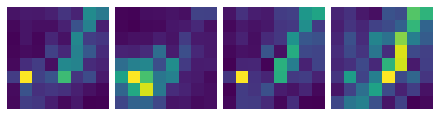

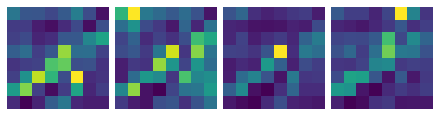

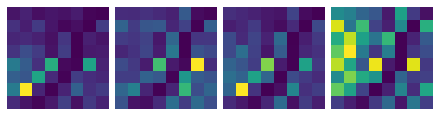

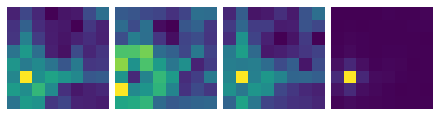

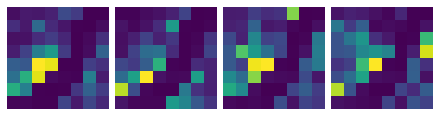

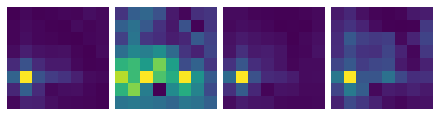

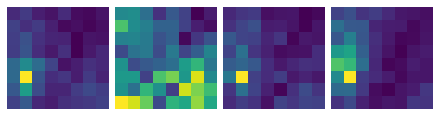

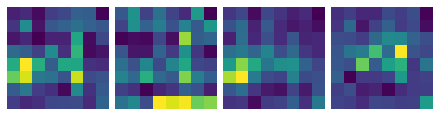

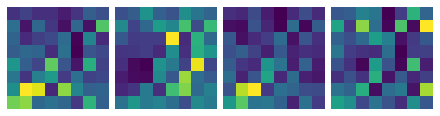

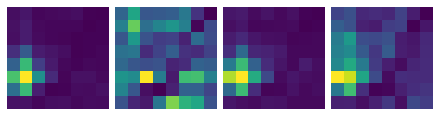

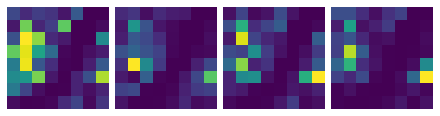

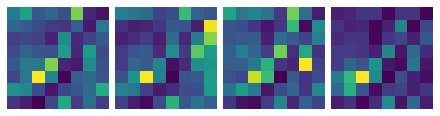

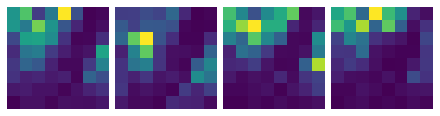

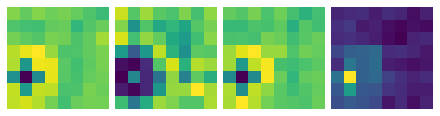

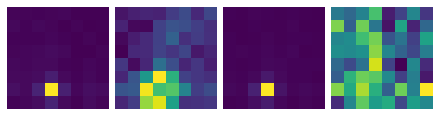

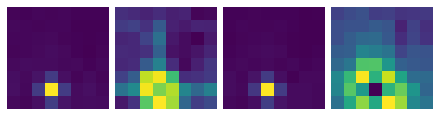

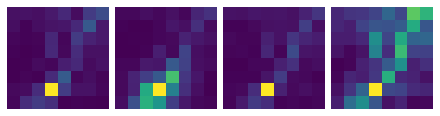

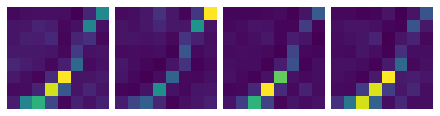

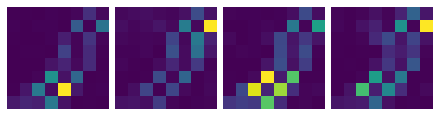

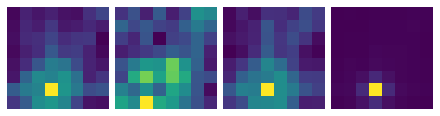

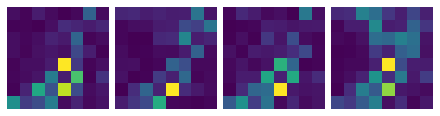

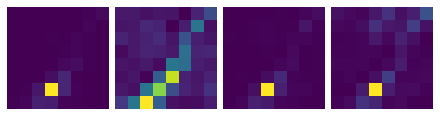

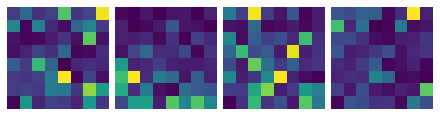

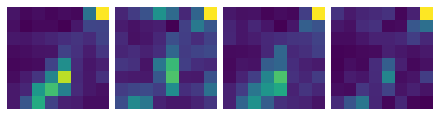

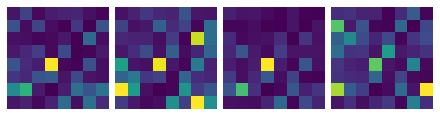

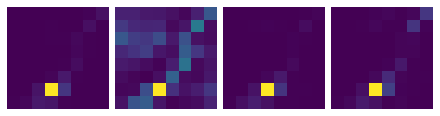

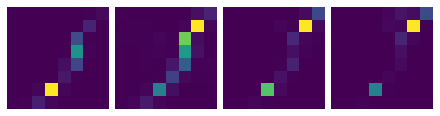

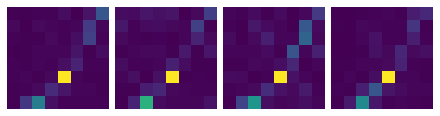

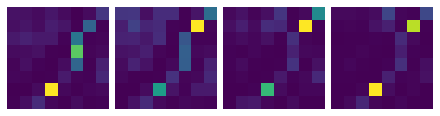

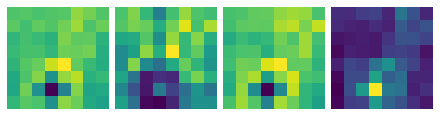

In [22]:
frame_idx = 1
loc11 = [62, 36]
loc12 = [62, 38]
loc21 = [73, 45]
loc22 = [75, 46]
windows1 = (loc11[0]//8 * 8, loc11[1]//8 * 8)
windows2 = (loc21[0]//8 * 8, loc21[1]//8 * 8)

fig, axs = plt.subplots(1, 4, constrained_layout=True)
for i in range(4): 
    test = imgs_LR[i*2, :,windows1[1]:windows1[1]+8, windows1[0]:windows1[0]+8].permute(1, 2, 0)
    if i == frame_idx:
            axs[i].plot(loc11[0]-windows1[0],loc11[1]-windows1[1],'ro')
    axs[i].imshow(test)
    axs[i].axis('off')
plt.savefig('window1_point1.png', dpi=360, bbox_inches='tight', transparent=True)

fig, axs = plt.subplots(1, 4, constrained_layout=True)
for i in range(4): 
    test = imgs_LR[i*2, :,windows1[1]:windows1[1]+8, windows1[0]:windows1[0]+8].permute(1, 2, 0)
    if i == frame_idx:
            axs[i].plot(loc12[0]-windows1[0],loc12[1]-windows1[1],'mo')
    axs[i].imshow(test)
    axs[i].axis('off')
plt.savefig('window1_point2.png', dpi=360, bbox_inches='tight', transparent=True)


for i in range(16):
    attn_weights = enc_attn_weights[3][:, i, ...].view(-1, 4, 8, 8, 256)
    x = window_reverse(attn_weights, (8, 8), 1, 4, 64, 112)
    x = x.view(1, 4, 64, 112, 4, 8, 8)
    fig, axs = plt.subplots(1, 4, constrained_layout=True)
    for j in range(4):
        axs[j].imshow(x[0, frame_idx, loc11[1], loc11[0], j])
        axs[j].axis('off')
    plt.savefig('point1_window1_encoder4_attention_head{}.png'.format(i), dpi=360, bbox_inches='tight', transparent=True)
        
for i in range(16):
    attn_weights = enc_attn_weights[3][:, i, ...].view(-1, 4, 8, 8, 256)
    x = window_reverse(attn_weights, (8, 8), 1, 4, 64, 112)
    x = x.view(1, 4, 64, 112, 4, 8, 8)
    fig, axs = plt.subplots(1, 4, constrained_layout=True)
    for j in range(4):
        axs[j].imshow(x[0, frame_idx, loc12[1], loc12[0], j])
        axs[j].axis('off')
    plt.savefig('point2_window1_encoder4_attention_head{}.png'.format(i), dpi=360, bbox_inches='tight', transparent=True)
        
fig, axs = plt.subplots(1, 4, constrained_layout=True)
for i in range(4): 
    test = imgs_LR[i*2, :,windows2[1]:windows2[1]+8, windows2[0]:windows2[0]+8].permute(1, 2, 0)
    if i == frame_idx:
            axs[i].plot(loc21[0]-windows2[0],loc21[1]-windows2[1],'bo')
    axs[i].imshow(test)
    axs[i].axis('off')
plt.savefig('window2_point3.png', dpi=360, bbox_inches='tight', transparent=True)

fig, axs = plt.subplots(1, 4, constrained_layout=True)
for i in range(4): 
    test = imgs_LR[i*2, :,windows2[1]:windows2[1]+8, windows2[0]:windows2[0]+8].permute(1, 2, 0)
    if i == frame_idx:
            axs[i].plot(loc22[0]-windows2[0],loc22[1]-windows2[1],'co')
    axs[i].imshow(test)
    axs[i].axis('off')
plt.savefig('window2_point4.png', dpi=360, bbox_inches='tight', transparent=True)


for i in range(16):
    attn_weights = enc_attn_weights[3][:, i, ...].view(-1, 4, 8, 8, 256)
    x = window_reverse(attn_weights, (8, 8), 1, 4, 64, 112)
    x = x.view(1, 4, 64, 112, 4, 8, 8)
    fig, axs = plt.subplots(1, 4, constrained_layout=True)
    for j in range(4):
        axs[j].imshow(x[0, frame_idx, loc21[1], loc21[0], j])
        axs[j].axis('off')
    plt.savefig('point3_window2_encoder4_attention_head{}.png'.format(i), dpi=360, bbox_inches='tight', transparent=True)
        
for i in range(16):
    attn_weights = enc_attn_weights[3][:, i, ...].view(-1, 4, 8, 8, 256)
    x = window_reverse(attn_weights, (8, 8), 1, 4, 64, 112)
    x = x.view(1, 4, 64, 112, 4, 8, 8)
    fig, axs = plt.subplots(1, 4, constrained_layout=True)
    for j in range(4):
        axs[j].imshow(x[0, frame_idx, loc22[1], loc22[0], j])
        axs[j].axis('off')
    plt.savefig('point4_window2_encoder4_attention_head{}.png'.format(i), dpi=360, bbox_inches='tight', transparent=True)

<ipython-input-23-1ef32150cb4f>:44: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  fig, axs = plt.subplots(1, 4, constrained_layout=True)


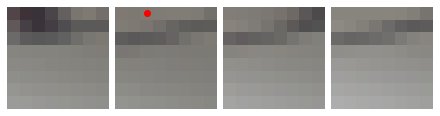

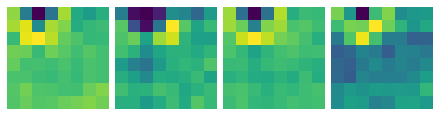

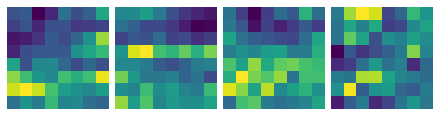

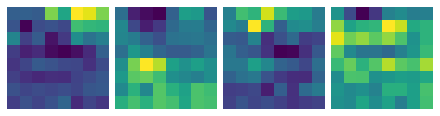

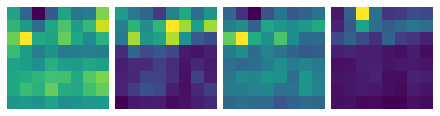

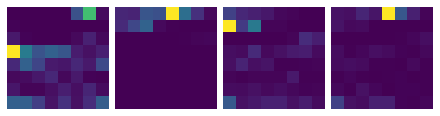

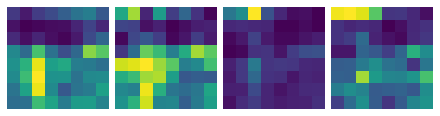

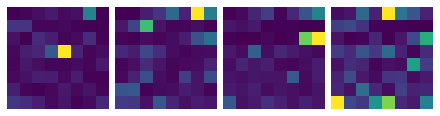

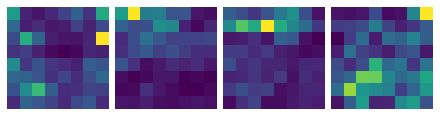

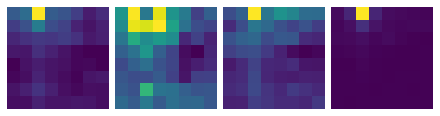

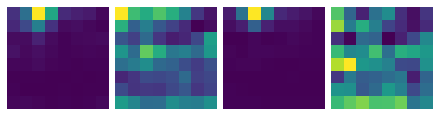

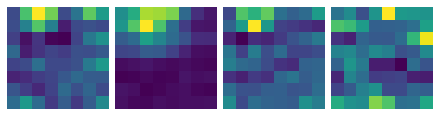

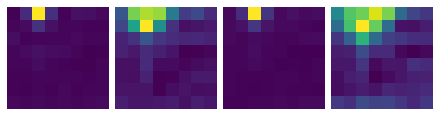

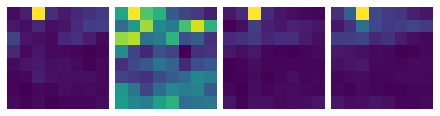

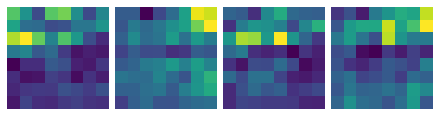

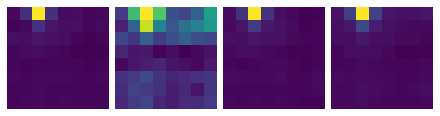

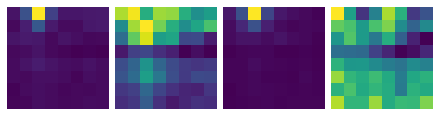

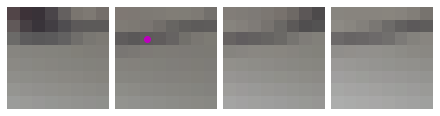

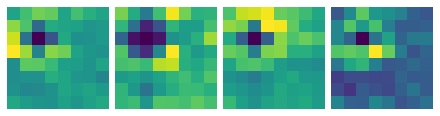

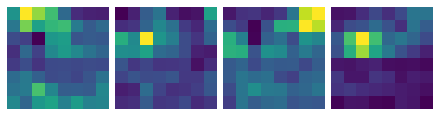

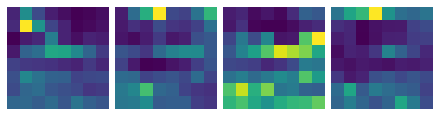

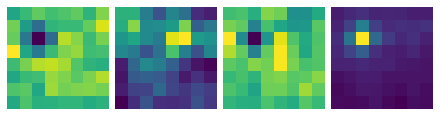

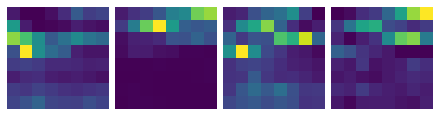

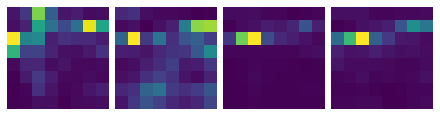

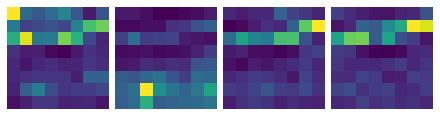

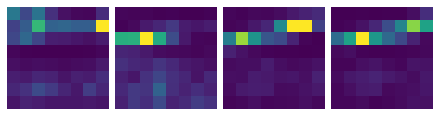

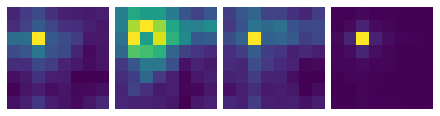

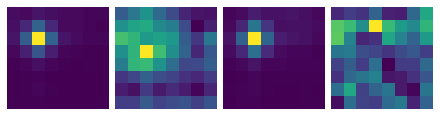

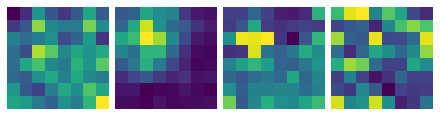

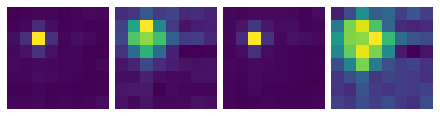

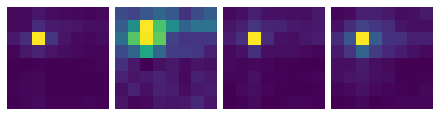

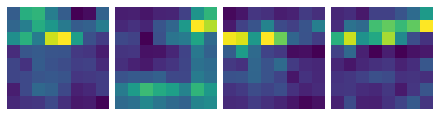

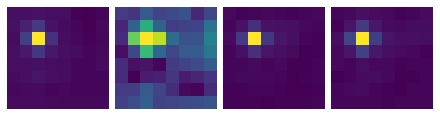

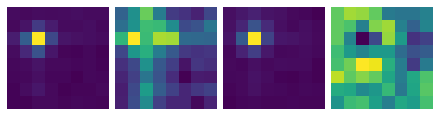

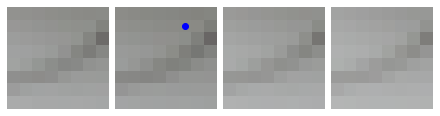

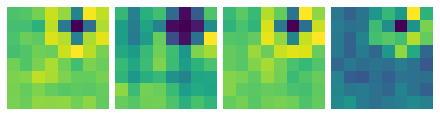

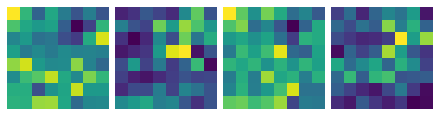

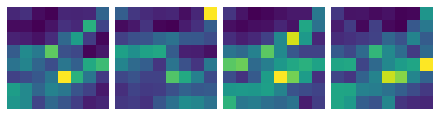

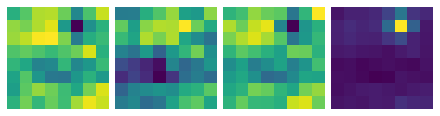

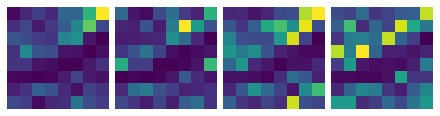

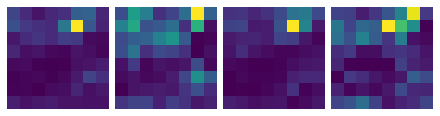

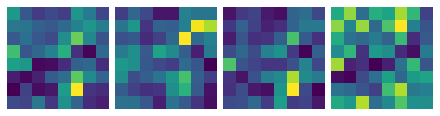

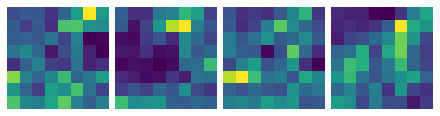

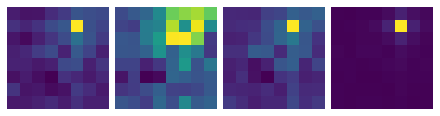

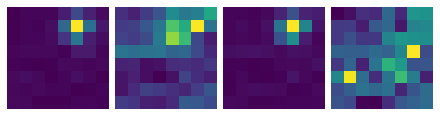

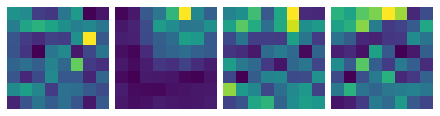

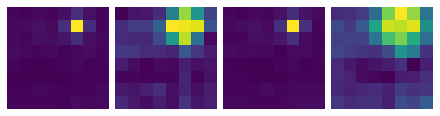

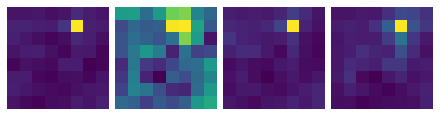

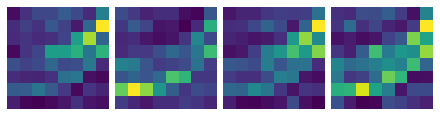

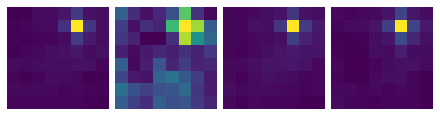

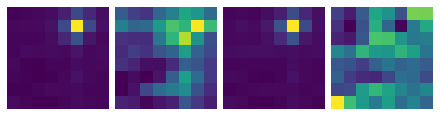

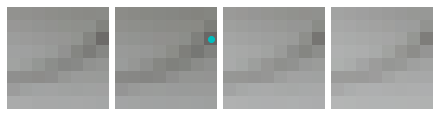

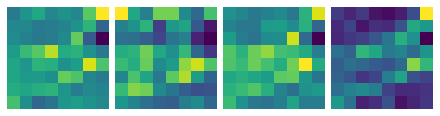

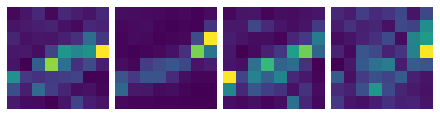

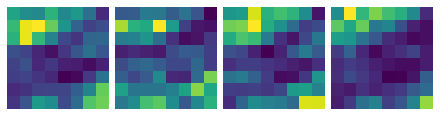

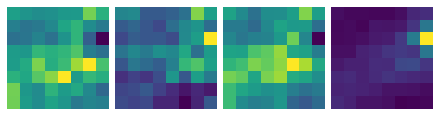

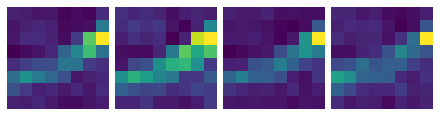

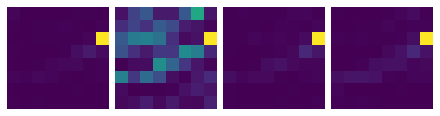

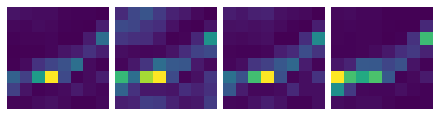

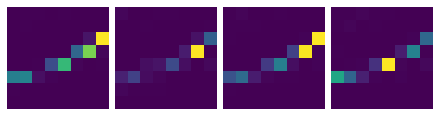

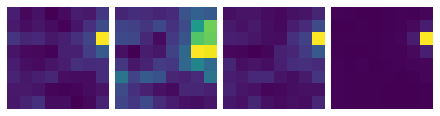

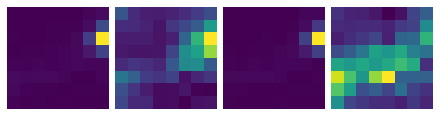

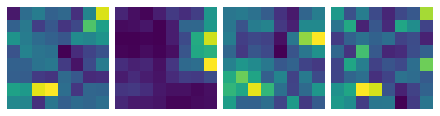

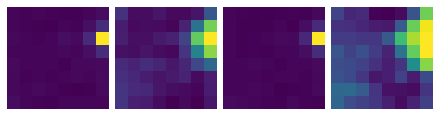

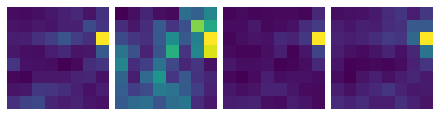

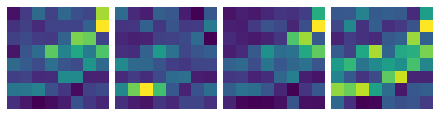

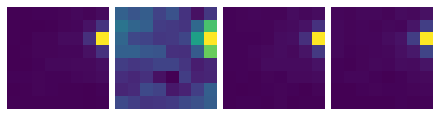

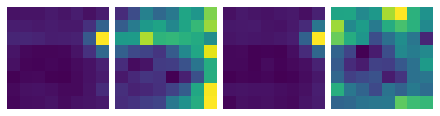

In [23]:
frame_idx = 1
loc11 = [62, 36]
loc12 = [62, 38]
loc21 = [73, 45]
loc22 = [75, 46]
windows1 = ((loc11[0]-4)//8 * 8 + 4, (loc11[1]-4)//8 * 8 + 4)
windows2 = ((loc21[0]-4)//8 * 8 + 4, (loc21[1]-4)//8 * 8 + 4)

fig, axs = plt.subplots(1, 4, constrained_layout=True)
for i in range(4): 
    test = imgs_LR[i*2, :,windows1[1]:windows1[1]+8, windows1[0]:windows1[0]+8].permute(1, 2, 0)
    if i == frame_idx:
            axs[i].plot(loc11[0]-windows1[0],loc11[1]-windows1[1],'ro')
    axs[i].imshow(test)
    axs[i].axis('off')
plt.savefig('shift_window1_point1.png', dpi=360, bbox_inches='tight', transparent=True)


for i in range(16):
    attn_weights = enc_shift_attn_weights[3][:, i, ...].view(-1, 4, 8, 8, 256)
    x = window_reverse(attn_weights, (8, 8), 1, 4, 64, 112)
    x = x.view(1, 4, 64, 112, 4, 8, 8)
    x = torch.roll(x, shifts=(4, 4), dims=(2, 3))
    fig, axs = plt.subplots(1, 4, constrained_layout=True)
    for j in range(4):
        axs[j].imshow(x[0, frame_idx, loc11[1], loc11[0], j])
        axs[j].axis('off')
    plt.savefig('point1_shift_window1_encoder4_attention_head{}.png'.format(i), dpi=360, bbox_inches='tight', transparent=True)

fig, axs = plt.subplots(1, 4, constrained_layout=True)
for i in range(4): 
    test = imgs_LR[i*2, :,windows1[1]:windows1[1]+8, windows1[0]:windows1[0]+8].permute(1, 2, 0)
    if i == frame_idx:
            axs[i].plot(loc12[0]-windows1[0],loc12[1]-windows1[1],'mo')
    axs[i].imshow(test)
    axs[i].axis('off')
plt.savefig('shift_window1_point2.png', dpi=360, bbox_inches='tight', transparent=True)
    
for i in range(16):
    attn_weights = enc_shift_attn_weights[3][:, i, ...].view(-1, 4, 8, 8, 256)
    x = window_reverse(attn_weights, (8, 8), 1, 4, 64, 112)
    x = x.view(1, 4, 64, 112, 4, 8, 8)
    x = torch.roll(x, shifts=(4, 4), dims=(2, 3))
    fig, axs = plt.subplots(1, 4, constrained_layout=True)
    for j in range(4):
        axs[j].imshow(x[0, frame_idx, loc12[1], loc12[0], j])
        axs[j].axis('off')
    plt.savefig('point2_shift_window1_encoder4_attention_head{}.png'.format(i), dpi=360, bbox_inches='tight', transparent=True)

    
    
fig, axs = plt.subplots(1, 4, constrained_layout=True)
for i in range(4): 
    test = imgs_LR[i*2, :,windows2[1]:windows2[1]+8, windows2[0]:windows2[0]+8].permute(1, 2, 0)
    if i == frame_idx:
            axs[i].plot(loc21[0]-windows2[0],loc21[1]-windows2[1],'bo')
    axs[i].imshow(test)
    axs[i].axis('off')
plt.savefig('shift_window2_point3.png', dpi=360, bbox_inches='tight', transparent=True)

for i in range(16):
    attn_weights = enc_shift_attn_weights[3][:, i, ...].view(-1, 4, 8, 8, 256)
    x = window_reverse(attn_weights, (8, 8), 1, 4, 64, 112)
    x = x.view(1, 4, 64, 112, 4, 8, 8)
    x = torch.roll(x, shifts=(4, 4), dims=(2, 3))
    fig, axs = plt.subplots(1, 4, constrained_layout=True)
    for j in range(4):
        axs[j].imshow(x[0, frame_idx, loc21[1], loc21[0], j])
        axs[j].axis('off')
    plt.savefig('point3_shift_window2_encoder4_attention_head{}.png'.format(i), dpi=360, bbox_inches='tight', transparent=True)

fig, axs = plt.subplots(1, 4, constrained_layout=True)
for i in range(4): 
    test = imgs_LR[i*2, :,windows2[1]:windows2[1]+8, windows2[0]:windows2[0]+8].permute(1, 2, 0)
    if i == frame_idx:
            axs[i].plot(loc22[0]-windows2[0],loc22[1]-windows2[1],'co')
    axs[i].imshow(test)
    axs[i].axis('off')
plt.savefig('shift_window2_point4.png', dpi=360, bbox_inches='tight', transparent=True)

for i in range(16):
    attn_weights = enc_shift_attn_weights[3][:, i, ...].view(-1, 4, 8, 8, 256)
    x = window_reverse(attn_weights, (8, 8), 1, 4, 64, 112)
    x = x.view(1, 4, 64, 112, 4, 8, 8)
    x = torch.roll(x, shifts=(4, 4), dims=(2, 3))
    fig, axs = plt.subplots(1, 4, constrained_layout=True)
    for j in range(4):
        axs[j].imshow(x[0, frame_idx, loc22[1], loc22[0], j])
        axs[j].axis('off')
    plt.savefig('point4_shift_window2_encoder4_attention_head{}.png'.format(i), dpi=360, bbox_inches='tight', transparent=True)

# Attention from first decoder 

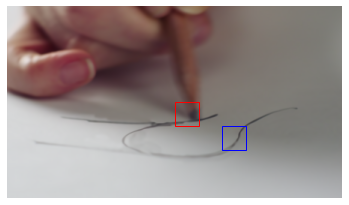

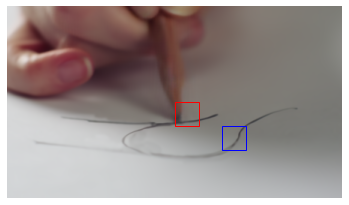

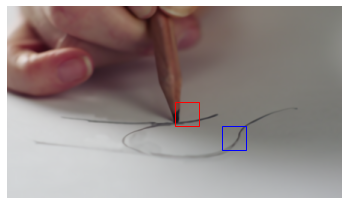

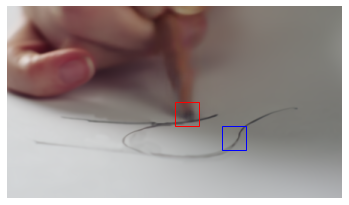

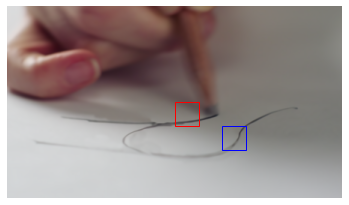

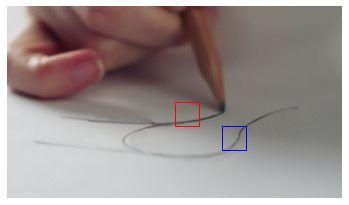

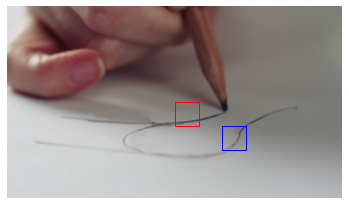

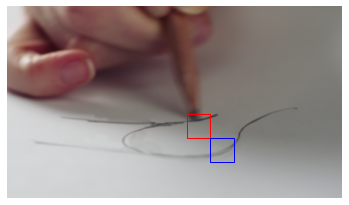

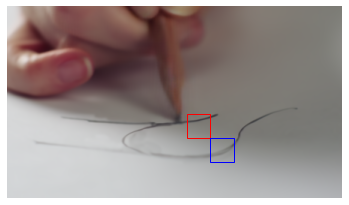

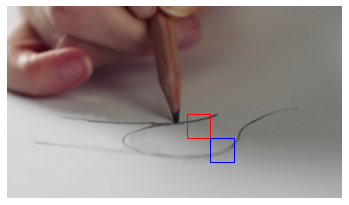

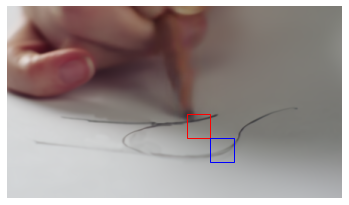

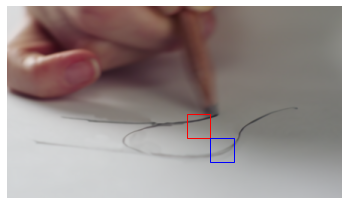

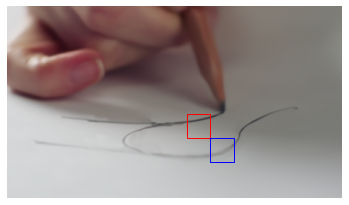

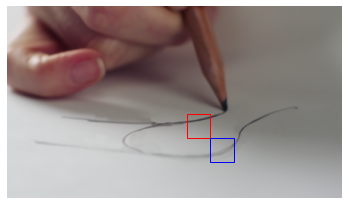

In [56]:
frame_idx = 3
loc11 = [62, 36]
loc12 = [62, 38]
loc21 = [73, 45]
loc22 = [75, 46]
windows1 = (loc11[0]//8 * 8, loc11[1]//8 * 8)
windows2 = (loc21[0]//8 * 8, loc21[1]//8 * 8)

for i in range(7):
    fig, ax = plt.subplots()
    ax.imshow(outputs[i].transpose(1, 2, 0))
    rect = patches.Rectangle((windows1[0]*4-0.5, windows1[1]*4-0.5), 32, 32, linewidth=1, edgecolor='r', facecolor='none')
    ax.add_patch(rect)
    rect = patches.Rectangle((windows2[0]*4-0.5, windows2[1]*4-0.5), 32, 32, linewidth=1, edgecolor='b', facecolor='none')
    ax.add_patch(rect)
    ax.axis('off')
    plt.savefig('img{}_attn_decoder.png'.format(i+1), bbox_inches='tight', transparent=True, dpi=360)
    plt.show()

windows1 = ((loc11[0]-4)//8 * 8 + 4, (loc11[1]-4)//8 * 8 + 4)
windows2 = ((loc21[0]-4)//8 * 8 + 4, (loc21[1]-4)//8 * 8 + 4)

for i in range(7):
    fig, ax = plt.subplots()
    ax.imshow(outputs[i].transpose(1, 2, 0))
    rect = patches.Rectangle((windows1[0]*4-0.5, windows1[1]*4-0.5), 32, 32, linewidth=1, edgecolor='r', facecolor='none')
    ax.add_patch(rect)
    rect = patches.Rectangle((windows2[0]*4-0.5, windows2[1]*4-0.5), 32, 32, linewidth=1, edgecolor='b', facecolor='none')
    ax.add_patch(rect)
    ax.axis('off')
    plt.savefig('img{}_shift_window_attn_decoder.png'.format(i+1), bbox_inches='tight', transparent=True, dpi=360)
    plt.show()


<ipython-input-43-2e247d2c6f19>:44: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  fig, axs = plt.subplots(1, 4, constrained_layout=True)


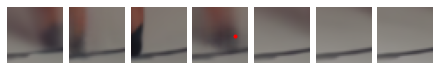

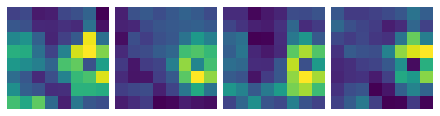

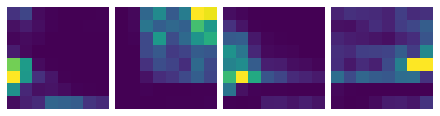

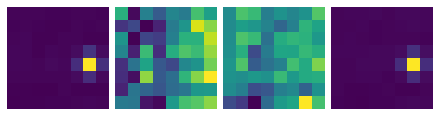

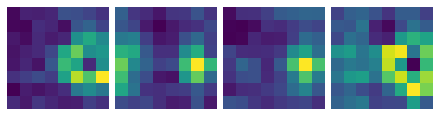

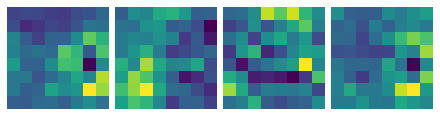

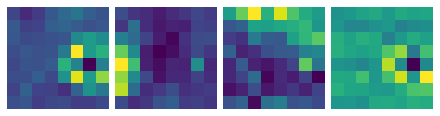

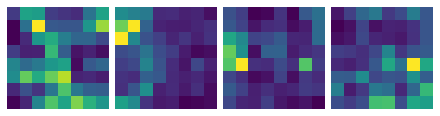

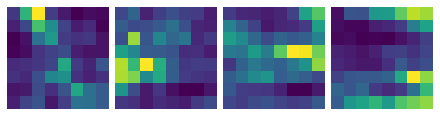

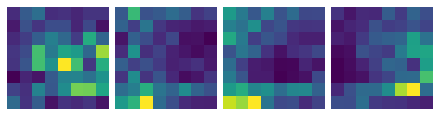

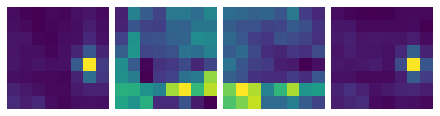

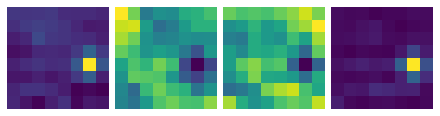

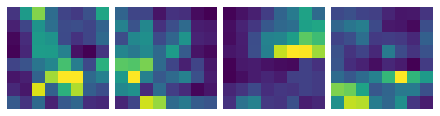

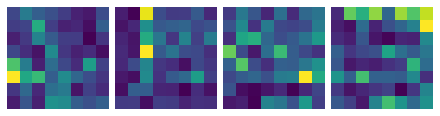

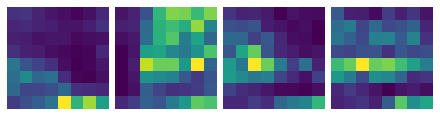

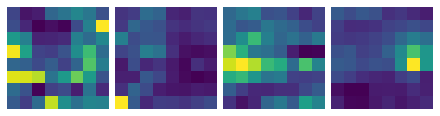

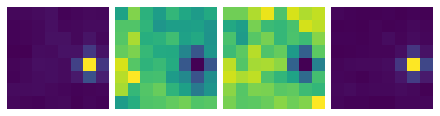

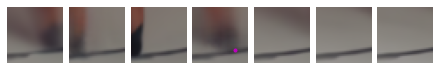

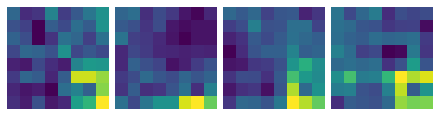

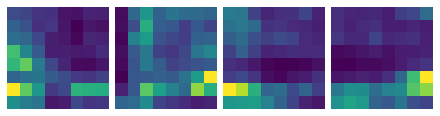

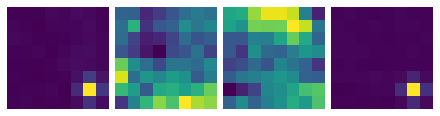

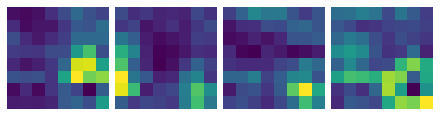

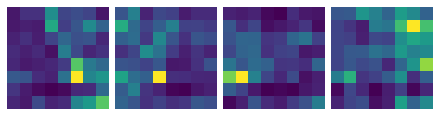

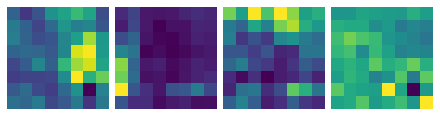

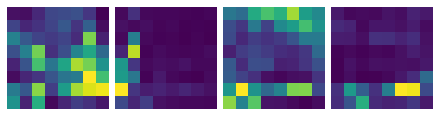

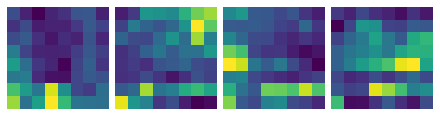

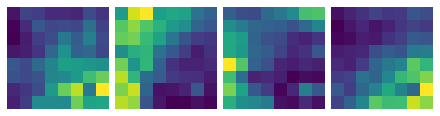

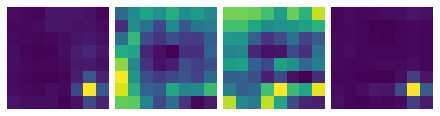

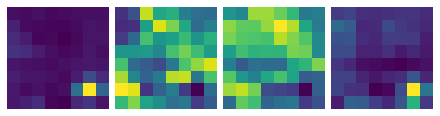

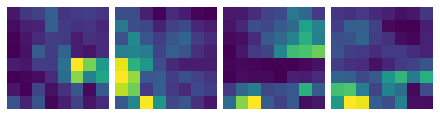

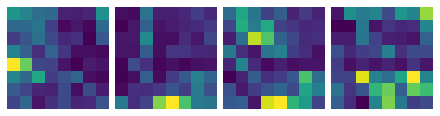

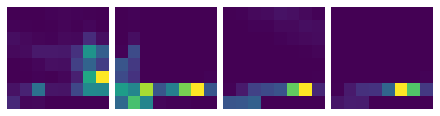

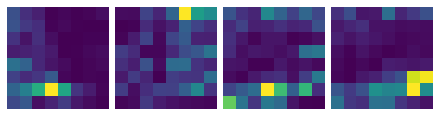

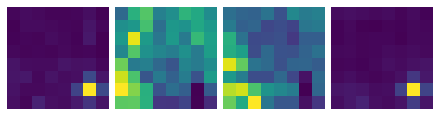

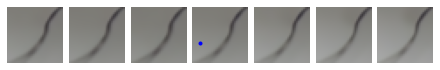

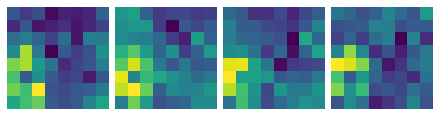

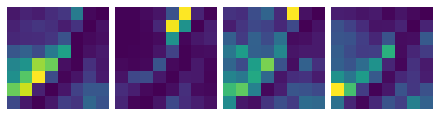

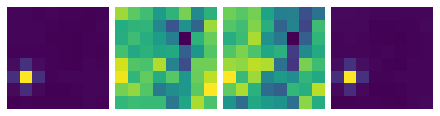

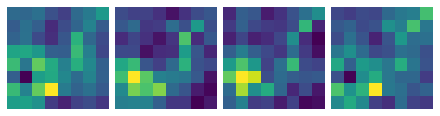

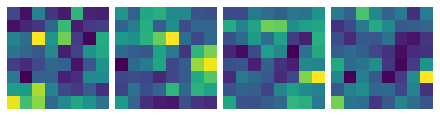

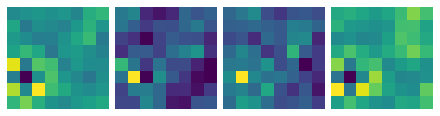

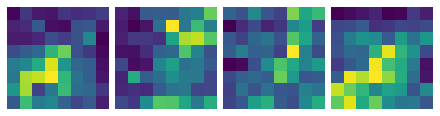

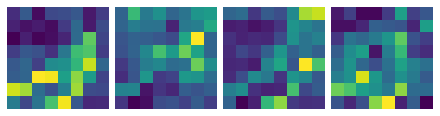

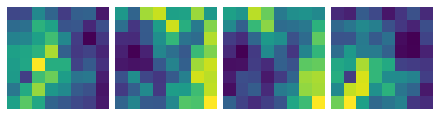

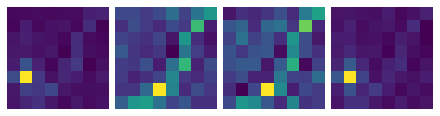

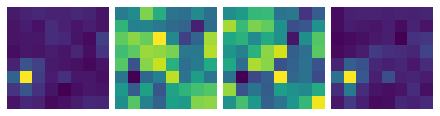

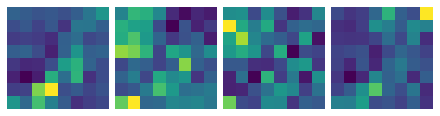

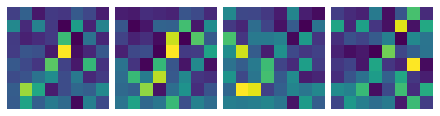

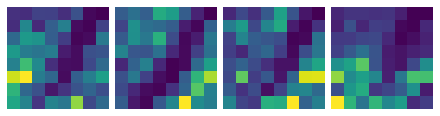

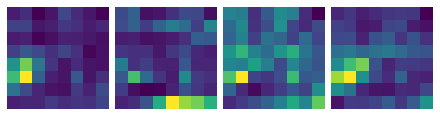

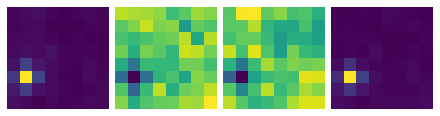

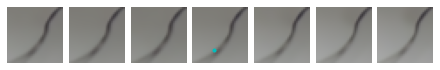

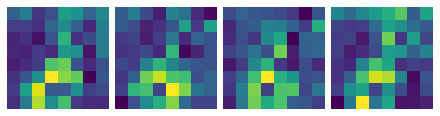

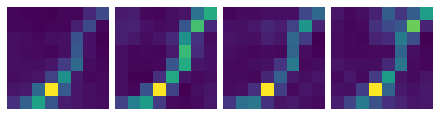

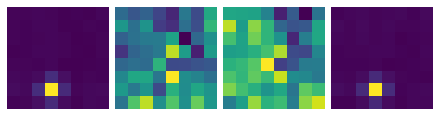

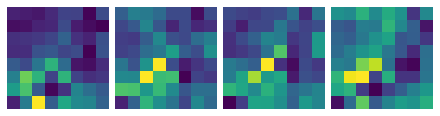

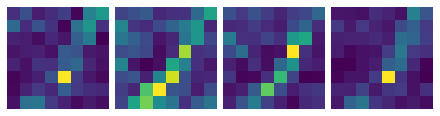

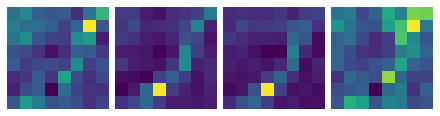

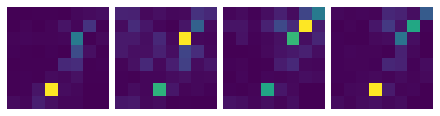

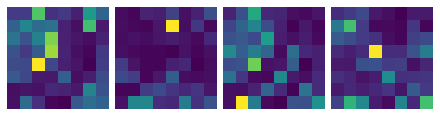

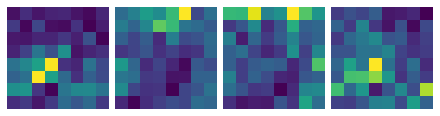

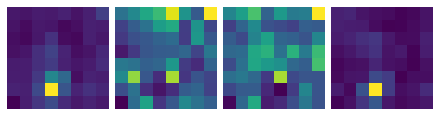

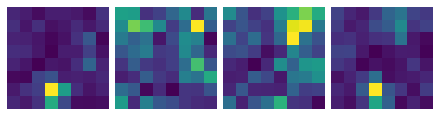

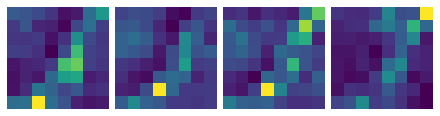

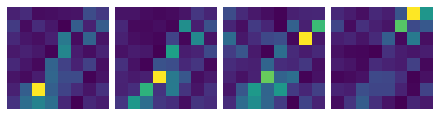

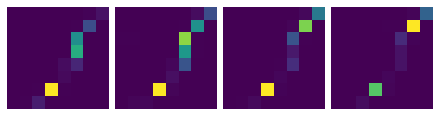

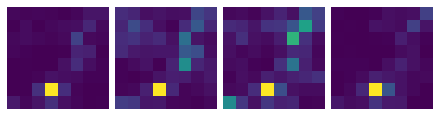

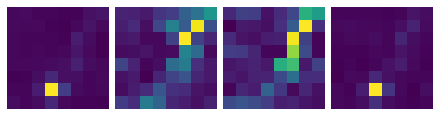

In [43]:
frame_idx = 3
loc11 = [62, 36]
loc12 = [62, 38]
loc21 = [73, 45]
loc22 = [75, 46]
windows1 = (loc11[0]//8 * 8, loc11[1]//8 * 8)
windows2 = (loc21[0]//8 * 8, loc21[1]//8 * 8)

fig, axs = plt.subplots(1, 7, constrained_layout=True)
for i in range(7): 
    test = outputs[i, :,windows1[1]*4:windows1[1]*4+32, windows1[0]*4:windows1[0]*4+32].transpose(1, 2, 0)
    if i == frame_idx:
            axs[i].plot(loc11[0]*4-windows1[0]*4,loc11[1]*4-windows1[1]*4,'ro', markersize=3)
    axs[i].imshow(test)
    axs[i].axis('off')
plt.savefig('window1_point1_decoder.png', dpi=360, bbox_inches='tight', transparent=True)


for i in range(16):
    attn_weights = dec_attn_weights[0][:, i, ...].view(-1, 7, 8, 8, 256)
    x = window_reverse(attn_weights, (8, 8), 1, 7, 64, 112)
    x = x.view(1, 7, 64, 112, 4, 8, 8)
    fig, axs = plt.subplots(1, 4, constrained_layout=True)
    for j in range(4):
        axs[j].imshow(x[0, frame_idx, loc11[1], loc11[0], j])
        axs[j].axis('off')
    plt.savefig('point1_window1_decoder4_attention_head{}.png'.format(i), dpi=360, bbox_inches='tight', transparent=True)
        

fig, axs = plt.subplots(1, 7, constrained_layout=True)
for i in range(7): 
    test = outputs[i, :,windows1[1]*4:windows1[1]*4+32, windows1[0]*4:windows1[0]*4+32].transpose(1, 2, 0)
    if i == frame_idx:
            axs[i].plot(loc12[0]*4-windows1[0]*4,loc12[1]*4-windows1[1]*4,'mo', markersize=3)
    axs[i].imshow(test)
    axs[i].axis('off')
plt.savefig('window1_point2_decoder.png', dpi=360, bbox_inches='tight', transparent=True)

        
for i in range(16):
    attn_weights = dec_attn_weights[0][:, i, ...].view(-1, 7, 8, 8, 256)
    x = window_reverse(attn_weights, (8, 8), 1, 7, 64, 112)
    x = x.view(1, 7, 64, 112, 4, 8, 8)
    fig, axs = plt.subplots(1, 4, constrained_layout=True)
    for j in range(4):
        axs[j].imshow(x[0, frame_idx, loc12[1], loc12[0], j])
        axs[j].axis('off')
    plt.savefig('point2_window1_decoder4_attention_head{}.png'.format(i), dpi=360, bbox_inches='tight', transparent=True)
        
fig, axs = plt.subplots(1, 7, constrained_layout=True)
for i in range(7): 
    test = outputs[i, :,windows2[1]*4:windows2[1]*4+32, windows2[0]*4:windows2[0]*4+32].transpose(1, 2, 0)
    if i == frame_idx:
            axs[i].plot(loc21[0]*4-windows2[0]*4,loc21[1]*4-windows2[1]*4,'bo', markersize=3)
    axs[i].imshow(test)
    axs[i].axis('off')
plt.savefig('window2_point3_decoder.png', dpi=360, bbox_inches='tight', transparent=True)


for i in range(16):
    attn_weights = dec_attn_weights[0][:, i, ...].view(-1, 7, 8, 8, 256)
    x = window_reverse(attn_weights, (8, 8), 1, 7, 64, 112)
    x = x.view(1, 7, 64, 112, 4, 8, 8)
    fig, axs = plt.subplots(1, 4, constrained_layout=True)
    for j in range(4):
        axs[j].imshow(x[0, frame_idx, loc21[1], loc21[0], j])
        axs[j].axis('off')
    plt.savefig('point3_window2_decoder4_attention_head{}.png'.format(i), dpi=360, bbox_inches='tight', transparent=True)
        
fig, axs = plt.subplots(1, 7, constrained_layout=True)
for i in range(7): 
    test = outputs[i, :,windows2[1]*4:windows2[1]*4+32, windows2[0]*4:windows2[0]*4+32].transpose(1, 2, 0)
    if i == frame_idx:
            axs[i].plot(loc22[0]*4-windows2[0]*4,loc22[1]*4-windows2[1]*4,'co', markersize=3)
    axs[i].imshow(test)
    axs[i].axis('off')
plt.savefig('window2_point4_decoder.png', dpi=360, bbox_inches='tight', transparent=True)
        
for i in range(16):
    attn_weights = dec_attn_weights[0][:, i, ...].view(-1, 7, 8, 8, 256)
    x = window_reverse(attn_weights, (8, 8), 1, 7, 64, 112)
    x = x.view(1, 7, 64, 112, 4, 8, 8)
    fig, axs = plt.subplots(1, 4, constrained_layout=True)
    for j in range(4):
        axs[j].imshow(x[0, frame_idx, loc22[1], loc22[0], j])
        axs[j].axis('off')
    plt.savefig('point4_window2_decoder4_attention_head{}.png'.format(i), dpi=360, bbox_inches='tight', transparent=True)

<ipython-input-46-b406372210a8>:46: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  fig, axs = plt.subplots(1, 4, constrained_layout=True)


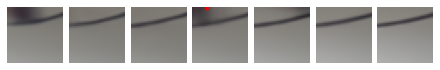

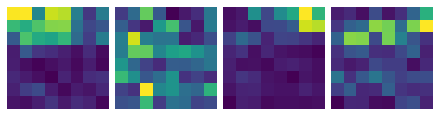

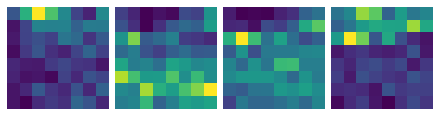

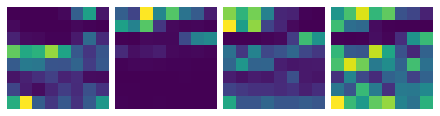

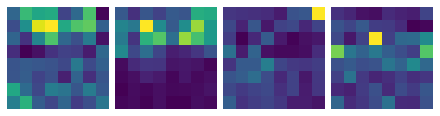

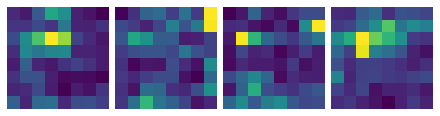

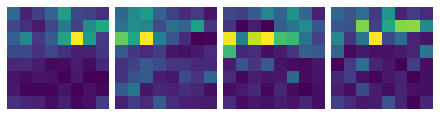

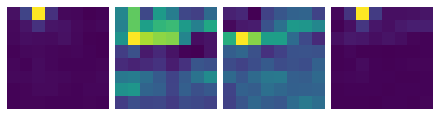

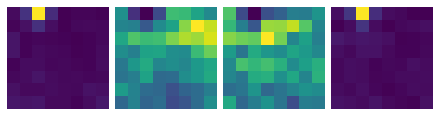

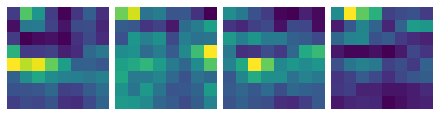

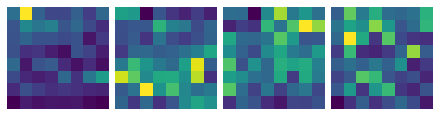

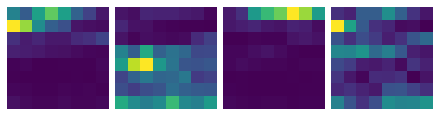

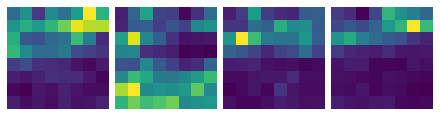

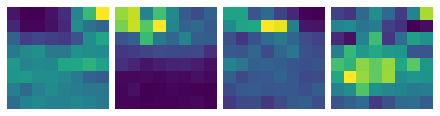

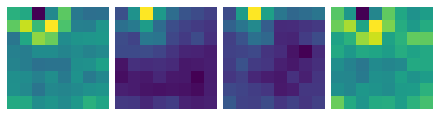

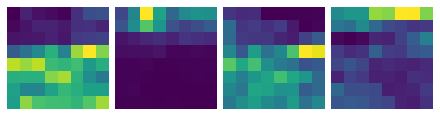

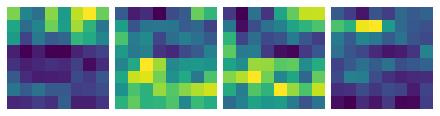

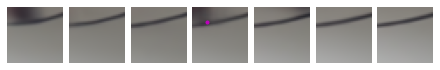

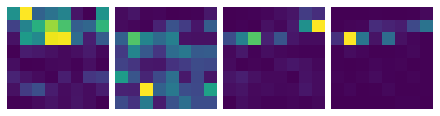

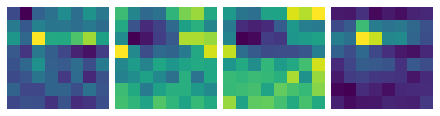

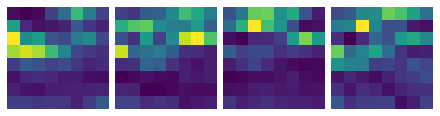

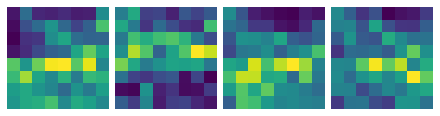

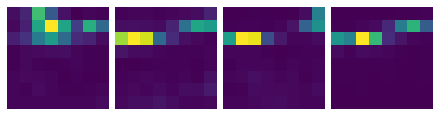

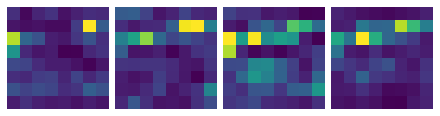

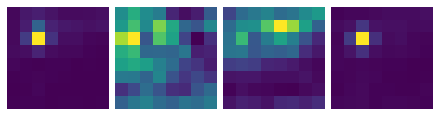

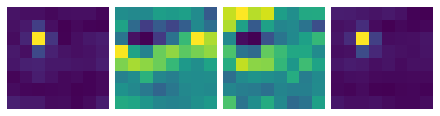

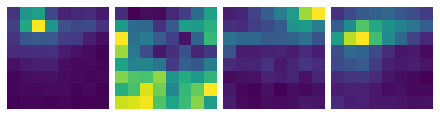

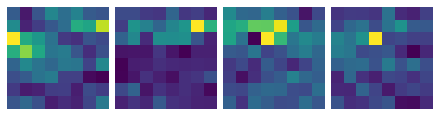

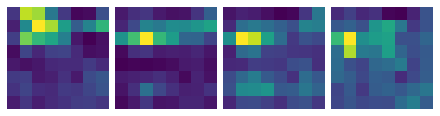

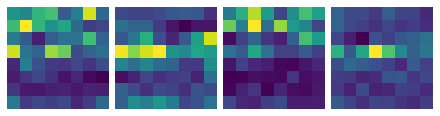

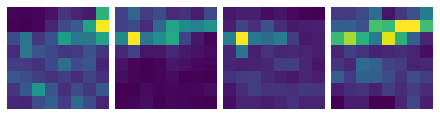

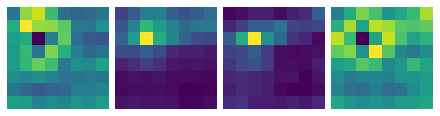

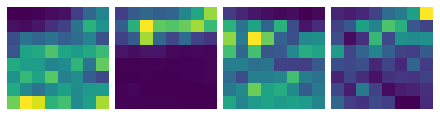

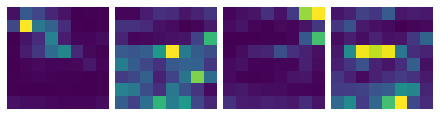

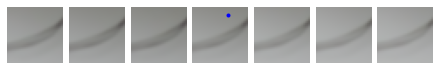

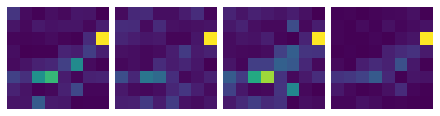

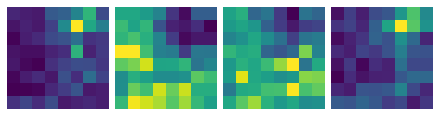

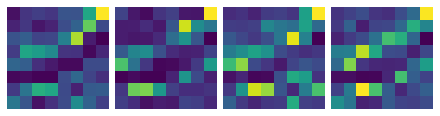

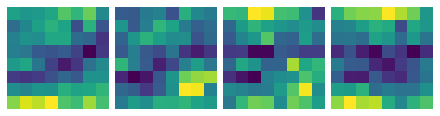

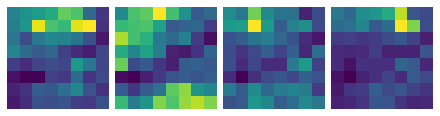

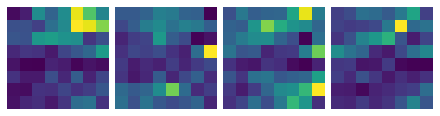

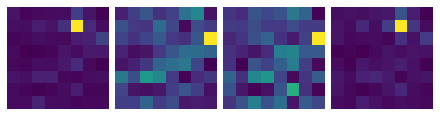

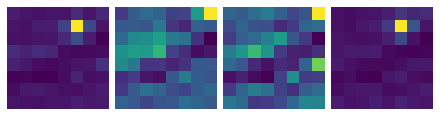

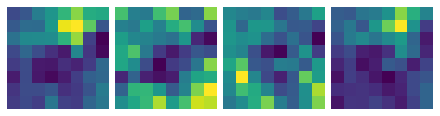

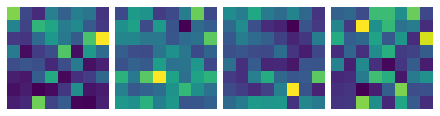

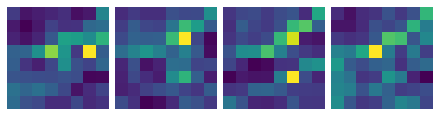

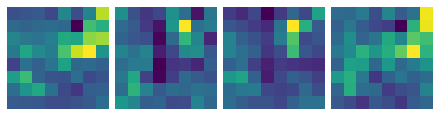

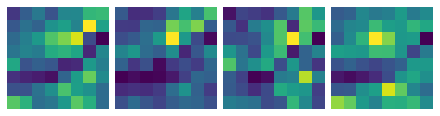

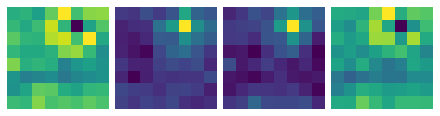

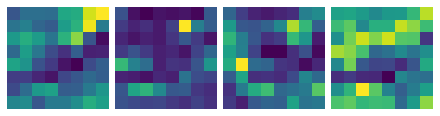

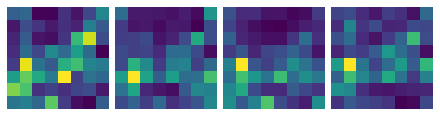

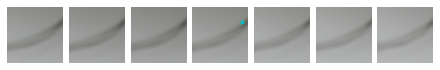

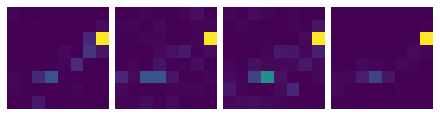

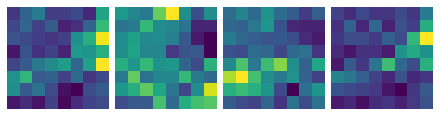

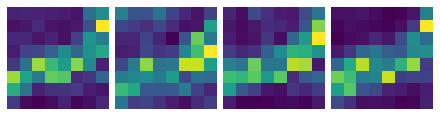

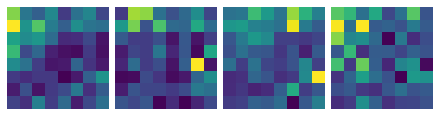

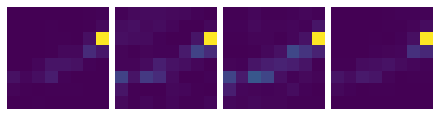

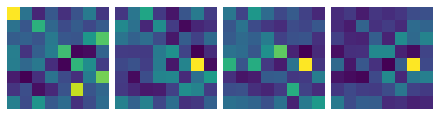

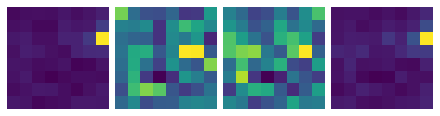

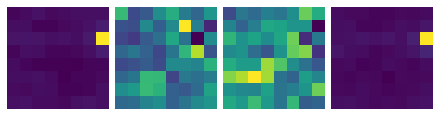

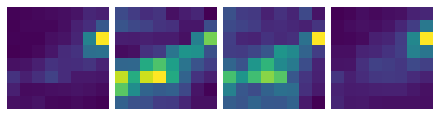

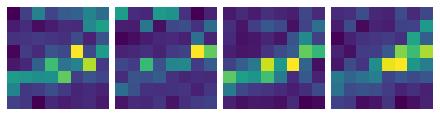

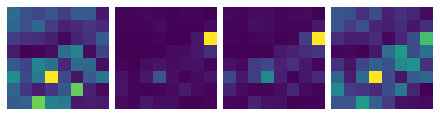

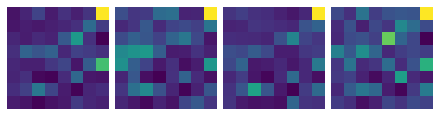

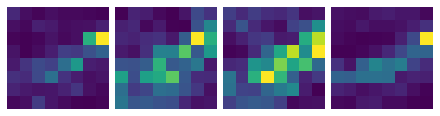

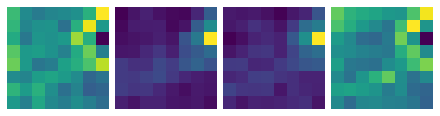

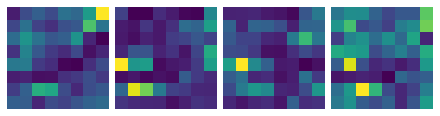

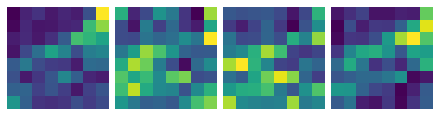

In [46]:
frame_idx = 3
loc11 = [62, 36]
loc12 = [62, 38]
loc21 = [73, 45]
loc22 = [75, 46]
windows1 = ((loc11[0]-4)//8 * 8 + 4, (loc11[1]-4)//8 * 8 + 4)
windows2 = ((loc21[0]-4)//8 * 8 + 4, (loc21[1]-4)//8 * 8 + 4)

fig, axs = plt.subplots(1, 7, constrained_layout=True)
for i in range(7): 
    test = outputs[i, :,windows1[1]*4:windows1[1]*4+32, windows1[0]*4:windows1[0]*4+32].transpose(1, 2, 0)
    if i == frame_idx:
            axs[i].plot(loc11[0]*4-windows1[0]*4,loc11[1]*4-windows1[1]*4,'ro', markersize=3)
    axs[i].imshow(test)
    axs[i].axis('off')
plt.savefig('shift_window1_point1_decoder.png', dpi=360, bbox_inches='tight', transparent=True)


for i in range(16):
    attn_weights = dec_shift_attn_weights[0][:, i, ...].view(-1, 7, 8, 8, 256)
    x = window_reverse(attn_weights, (8, 8), 1, 7, 64, 112)
    x = x.view(1, 7, 64, 112, 4, 8, 8)
    x = torch.roll(x, shifts=(4, 4), dims=(2, 3))
    fig, axs = plt.subplots(1, 4, constrained_layout=True)
    for j in range(4):
        axs[j].imshow(x[0, frame_idx, loc11[1], loc11[0], j])
        axs[j].axis('off')
    plt.savefig('point1_shift_window1_decoder4_attention_head{}.png'.format(i), dpi=360, bbox_inches='tight', transparent=True)
        

fig, axs = plt.subplots(1, 7, constrained_layout=True)
for i in range(7): 
    test = outputs[i, :,windows1[1]*4:windows1[1]*4+32, windows1[0]*4:windows1[0]*4+32].transpose(1, 2, 0)
    if i == frame_idx:
            axs[i].plot(loc12[0]*4-windows1[0]*4,loc12[1]*4-windows1[1]*4,'mo', markersize=3)
    axs[i].imshow(test)
    axs[i].axis('off')
plt.savefig('shift_window1_point2_decoder.png', dpi=360, bbox_inches='tight', transparent=True)

        
for i in range(16):
    attn_weights = dec_shift_attn_weights[0][:, i, ...].view(-1, 7, 8, 8, 256)
    x = window_reverse(attn_weights, (8, 8), 1, 7, 64, 112)
    x = x.view(1, 7, 64, 112, 4, 8, 8)
    x = torch.roll(x, shifts=(4, 4), dims=(2, 3))
    fig, axs = plt.subplots(1, 4, constrained_layout=True)
    for j in range(4):
        axs[j].imshow(x[0, frame_idx, loc12[1], loc12[0], j])
        axs[j].axis('off')
    plt.savefig('point2_shift_window1_decoder4_attention_head{}.png'.format(i), dpi=360, bbox_inches='tight', transparent=True)
        
fig, axs = plt.subplots(1, 7, constrained_layout=True)
for i in range(7): 
    test = outputs[i, :,windows2[1]*4:windows2[1]*4+32, windows2[0]*4:windows2[0]*4+32].transpose(1, 2, 0)
    if i == frame_idx:
            axs[i].plot(loc21[0]*4-windows2[0]*4,loc21[1]*4-windows2[1]*4,'bo', markersize=3)
    axs[i].imshow(test)
    axs[i].axis('off')
plt.savefig('shift_window2_point3_decoder.png', dpi=360, bbox_inches='tight', transparent=True)


for i in range(16):
    attn_weights = dec_shift_attn_weights[0][:, i, ...].view(-1, 7, 8, 8, 256)
    x = window_reverse(attn_weights, (8, 8), 1, 7, 64, 112)
    x = x.view(1, 7, 64, 112, 4, 8, 8)
    x = torch.roll(x, shifts=(4, 4), dims=(2, 3))
    fig, axs = plt.subplots(1, 4, constrained_layout=True)
    for j in range(4):
        axs[j].imshow(x[0, frame_idx, loc21[1], loc21[0], j])
        axs[j].axis('off')
    plt.savefig('point3_shift_window2_decoder4_attention_head{}.png'.format(i), dpi=360, bbox_inches='tight', transparent=True)
        
fig, axs = plt.subplots(1, 7, constrained_layout=True)
for i in range(7): 
    test = outputs[i, :,windows2[1]*4:windows2[1]*4+32, windows2[0]*4:windows2[0]*4+32].transpose(1, 2, 0)
    if i == frame_idx:
            axs[i].plot(loc22[0]*4-windows2[0]*4,loc22[1]*4-windows2[1]*4,'co', markersize=3)
    axs[i].imshow(test)
    axs[i].axis('off')
plt.savefig('shift_window2_point4_decoder.png', dpi=360, bbox_inches='tight', transparent=True)
        
for i in range(16):
    attn_weights = dec_shift_attn_weights[0][:, i, ...].view(-1, 7, 8, 8, 256)
    x = window_reverse(attn_weights, (8, 8), 1, 7, 64, 112)
    x = torch.roll(x, shifts=(4, 4), dims=(2, 3))
    x = x.view(1, 7, 64, 112, 4, 8, 8)
    fig, axs = plt.subplots(1, 4, constrained_layout=True)
    for j in range(4):
        axs[j].imshow(x[0, frame_idx, loc22[1], loc22[0], j])
        axs[j].axis('off')
    plt.savefig('point4_shift_window2_decoder4_attention_head{}.png'.format(i), dpi=360, bbox_inches='tight', transparent=True)

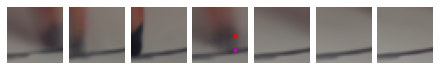

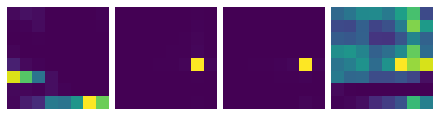

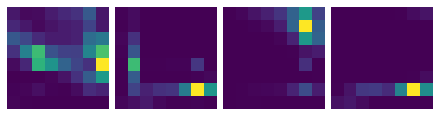

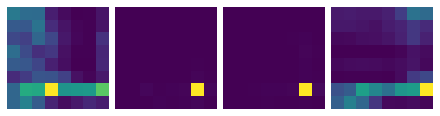

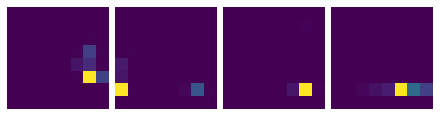

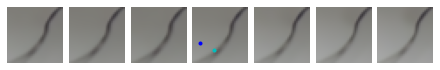

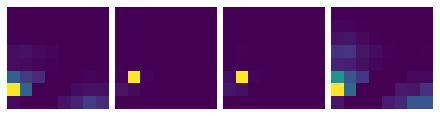

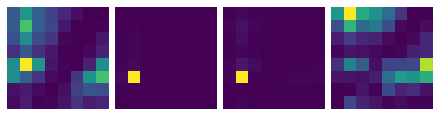

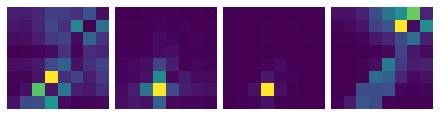

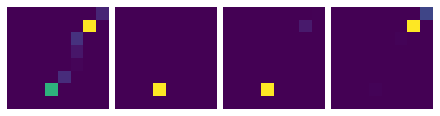

In [45]:
frame_idx = 3
loc11 = [62, 36]
loc12 = [62, 38]
loc21 = [73, 45]
loc22 = [75, 46]
windows1 = (loc11[0]//8 * 8, loc11[1]//8 * 8)
windows2 = (loc21[0]//8 * 8, loc21[1]//8 * 8)

fig, axs = plt.subplots(1, 7, constrained_layout=True)
for i in range(7): 
    test = outputs[i, :,windows1[1]*4:windows1[1]*4+32, windows1[0]*4:windows1[0]*4+32].transpose(1, 2, 0)
    if i == frame_idx:
            axs[i].plot(loc11[0]*4-windows1[0]*4,loc11[1]*4-windows1[1]*4,'ro', markersize=3)
            axs[i].plot(loc12[0]*4-windows1[0]*4,loc12[1]*4-windows1[1]*4,'mo', markersize=3)
    axs[i].imshow(test)
    axs[i].axis('off')
plt.savefig('window1_decoder.png', dpi=360, bbox_inches='tight', transparent=True)


for i in range(2):
    attn_weights = dec_attn_weights[3][:, i, ...].view(-1, 7, 8, 8, 256)
    x = window_reverse(attn_weights, (8, 8), 1, 7, 64, 112)
    x = x.view(1, 7, 64, 112, 4, 8, 8)
    fig, axs = plt.subplots(1, 4, constrained_layout=True)
    for j in range(4):
        axs[j].imshow(x[0, frame_idx, loc11[1], loc11[0], j])
        axs[j].axis('off')
    plt.savefig('point1_window1_decoder1_attention_head{}.png'.format(i), dpi=360, bbox_inches='tight', transparent=True)

        
for i in range(2):
    attn_weights = dec_attn_weights[3][:, i, ...].view(-1, 7, 8, 8, 256)
    x = window_reverse(attn_weights, (8, 8), 1, 7, 64, 112)
    x = x.view(1, 7, 64, 112, 4, 8, 8)
    fig, axs = plt.subplots(1, 4, constrained_layout=True)
    for j in range(4):
        axs[j].imshow(x[0, frame_idx, loc12[1], loc12[0], j])
        axs[j].axis('off')
    plt.savefig('point2_window1_decoder1_attention_head{}.png'.format(i), dpi=360, bbox_inches='tight', transparent=True)
        
fig, axs = plt.subplots(1, 7, constrained_layout=True)
for i in range(7): 
    test = outputs[i, :,windows2[1]*4:windows2[1]*4+32, windows2[0]*4:windows2[0]*4+32].transpose(1, 2, 0)
    if i == frame_idx:
            axs[i].plot(loc21[0]*4-windows2[0]*4,loc21[1]*4-windows2[1]*4,'bo', markersize=3)
            axs[i].plot(loc22[0]*4-windows2[0]*4,loc22[1]*4-windows2[1]*4,'co', markersize=3)
    axs[i].imshow(test)
    axs[i].axis('off')
plt.savefig('window2_decoder.png', dpi=360, bbox_inches='tight', transparent=True)


for i in range(2):
    attn_weights = dec_attn_weights[3][:, i, ...].view(-1, 7, 8, 8, 256)
    x = window_reverse(attn_weights, (8, 8), 1, 7, 64, 112)
    x = x.view(1, 7, 64, 112, 4, 8, 8)
    fig, axs = plt.subplots(1, 4, constrained_layout=True)
    for j in range(4):
        axs[j].imshow(x[0, frame_idx, loc21[1], loc21[0], j])
        axs[j].axis('off')
    plt.savefig('point3_window2_decoder1_attention_head{}.png'.format(i), dpi=360, bbox_inches='tight', transparent=True)
        
        
for i in range(2):
    attn_weights = dec_attn_weights[3][:, i, ...].view(-1, 7, 8, 8, 256)
    x = window_reverse(attn_weights, (8, 8), 1, 7, 64, 112)
    x = x.view(1, 7, 64, 112, 4, 8, 8)
    fig, axs = plt.subplots(1, 4, constrained_layout=True)
    for j in range(4):
        axs[j].imshow(x[0, frame_idx, loc22[1], loc22[0], j])
        axs[j].axis('off')
    plt.savefig('point4_window2_decoder1_attention_head{}.png'.format(i), dpi=360, bbox_inches='tight', transparent=True)

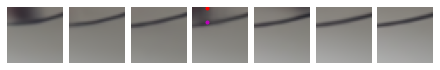

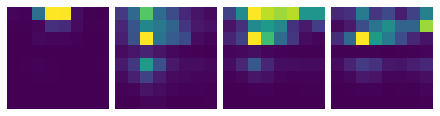

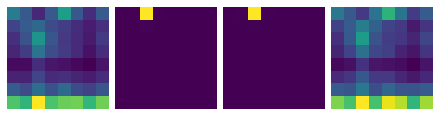

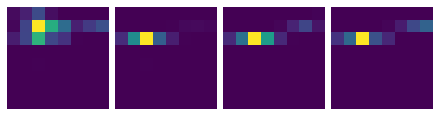

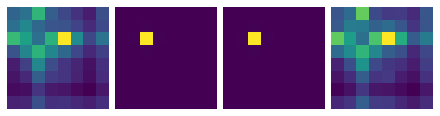

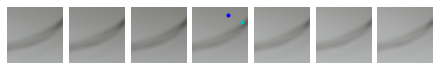

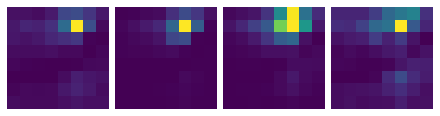

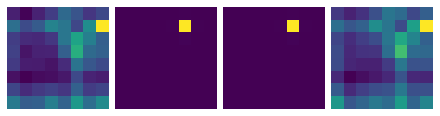

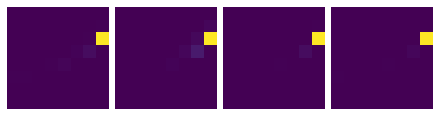

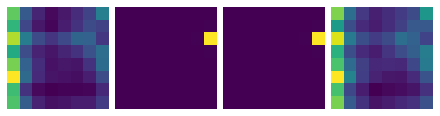

In [48]:
frame_idx = 3
loc11 = [62, 36]
loc12 = [62, 38]
loc21 = [73, 45]
loc22 = [75, 46]
windows1 = ((loc11[0]-4)//8 * 8 + 4, (loc11[1]-4)//8 * 8 + 4)
windows2 = ((loc21[0]-4)//8 * 8 + 4, (loc21[1]-4)//8 * 8 + 4)

fig, axs = plt.subplots(1, 7, constrained_layout=True)
for i in range(7): 
    test = outputs[i, :,windows1[1]*4:windows1[1]*4+32, windows1[0]*4:windows1[0]*4+32].transpose(1, 2, 0)
    if i == frame_idx:
            axs[i].plot(loc11[0]*4-windows1[0]*4,loc11[1]*4-windows1[1]*4,'ro', markersize=3)
            axs[i].plot(loc12[0]*4-windows1[0]*4,loc12[1]*4-windows1[1]*4,'mo', markersize=3)
    axs[i].imshow(test)
    axs[i].axis('off')
plt.savefig('shift_window1_decoder.png', dpi=360, bbox_inches='tight', transparent=True)


for i in range(2):
    attn_weights = dec_shift_attn_weights[3][:, i, ...].view(-1, 7, 8, 8, 256)
    x = window_reverse(attn_weights, (8, 8), 1, 7, 64, 112)
    x = x.view(1, 7, 64, 112, 4, 8, 8)
    x = torch.roll(x, shifts=(4, 4), dims=(2, 3))
    fig, axs = plt.subplots(1, 4, constrained_layout=True)
    for j in range(4):
        axs[j].imshow(x[0, frame_idx, loc11[1], loc11[0], j])
        axs[j].axis('off')
    plt.savefig('point1_shift_window1_decoder1_attention_head{}.png'.format(i), dpi=360, bbox_inches='tight', transparent=True)

        
for i in range(2):
    attn_weights = dec_shift_attn_weights[3][:, i, ...].view(-1, 7, 8, 8, 256)
    x = window_reverse(attn_weights, (8, 8), 1, 7, 64, 112)
    x = x.view(1, 7, 64, 112, 4, 8, 8)
    x = torch.roll(x, shifts=(4, 4), dims=(2, 3))
    fig, axs = plt.subplots(1, 4, constrained_layout=True)
    for j in range(4):
        axs[j].imshow(x[0, frame_idx, loc12[1], loc12[0], j])
        axs[j].axis('off')
    plt.savefig('point2_shift_window1_decoder1_attention_head{}.png'.format(i), dpi=360, bbox_inches='tight', transparent=True)
        
fig, axs = plt.subplots(1, 7, constrained_layout=True)
for i in range(7): 
    test = outputs[i, :,windows2[1]*4:windows2[1]*4+32, windows2[0]*4:windows2[0]*4+32].transpose(1, 2, 0)
    if i == frame_idx:
            axs[i].plot(loc21[0]*4-windows2[0]*4,loc21[1]*4-windows2[1]*4,'bo', markersize=3)
            axs[i].plot(loc22[0]*4-windows2[0]*4,loc22[1]*4-windows2[1]*4,'co', markersize=3)
    axs[i].imshow(test)
    axs[i].axis('off')
plt.savefig('shift_window2_decoder.png', dpi=360, bbox_inches='tight', transparent=True)


for i in range(2):
    attn_weights = dec_shift_attn_weights[3][:, i, ...].view(-1, 7, 8, 8, 256)
    x = window_reverse(attn_weights, (8, 8), 1, 7, 64, 112)
    x = x.view(1, 7, 64, 112, 4, 8, 8)
    x = torch.roll(x, shifts=(4, 4), dims=(2, 3))
    fig, axs = plt.subplots(1, 4, constrained_layout=True)
    for j in range(4):
        axs[j].imshow(x[0, frame_idx, loc21[1], loc21[0], j])
        axs[j].axis('off')
    plt.savefig('point3_shift_window2_decoder1_attention_head{}.png'.format(i), dpi=360, bbox_inches='tight', transparent=True)

        
for i in range(2):
    attn_weights = dec_shift_attn_weights[3][:, i, ...].view(-1, 7, 8, 8, 256)
    x = window_reverse(attn_weights, (8, 8), 1, 7, 64, 112)
    x = torch.roll(x, shifts=(4, 4), dims=(2, 3))
    x = x.view(1, 7, 64, 112, 4, 8, 8)
    fig, axs = plt.subplots(1, 4, constrained_layout=True)
    for j in range(4):
        axs[j].imshow(x[0, frame_idx, loc22[1], loc22[0], j])
        axs[j].axis('off')
    plt.savefig('point4_shift_window2_decoder1_attention_head{}.png'.format(i), dpi=360, bbox_inches='tight', transparent=True)